In [53]:
import random
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from pylab import mpl, plt
import time
from sklearn.metrics import mean_squared_error

seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)



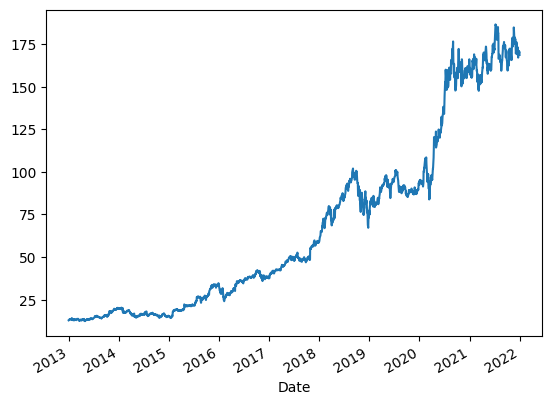

In [54]:


AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
dataset.head(10)
dataset['Close'].plot()

loss_curves=[]


In [55]:
dataset_close=dataset['Close']
dataset_close.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2266 entries, 2013-01-02 to 2021-12-30
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2266 non-null   float64
dtypes: float64(1)
memory usage: 35.4 KB


In [56]:
dataset_close.shape
test_size = int(np.round(0.2*dataset_close.shape[0]))
train_size = dataset_close.shape[0] - (test_size)
dataset_train = dataset_close[:train_size]
dataset_test = dataset_close[train_size:]

(453,)

In [57]:

sc = MinMaxScaler(feature_range=(0,1))
dataset_train_scaled = sc.fit_transform(dataset_train.values.reshape(-1,1))
dataset_test_scaled = sc.fit_transform(dataset_test.values.reshape(-1,1))

In [58]:

dataset_train_scaled = np.array(dataset_train_scaled)
dataset_test_scaled = np.array(dataset_test_scaled)

data_train = []
time_step = 100
# create all possible sequences of length look_back
for index in range(len(dataset_train_scaled) - time_step): 
    data_train.append(dataset_train_scaled[index: index + time_step])

data_train = np.array(data_train)
# test_timestamps = np.array(test_timestamps)

# test_size = int(np.round(0.2*data.shape[0]))
# train_size = data.shape[0] - (test_size)
# print(test_size)

X_train = data_train[:,:-1,:]
y_train = data_train[:,-1,:]

# X_test = data[train_size:,:-1]
# y_test = data[train_size:,-1,:]

# scale
# X_train = sc.fit_transform(X_train.reshape(-1,1))
# y_train = sc.fit_transform(y_train.reshape(-1,1))

# X_test = sc.fit_transform(X_test.reshape(-1,1))
# y_test = sc.fit_transform(y_test.reshape(-1,1))

data_test = []
# create all possible sequences of length look_back
for index in range(len(dataset_test_scaled) - time_step): 
    data_test.append(dataset_test_scaled[index: index + time_step])

data_test = np.array(data_test)


X_test = data_test[:,:-1]
y_test = data_test[:,-1,:]

In [59]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)


X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batch_size = 24
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [60]:
y_train.size(),X_train.size()


(torch.Size([1713, 1]), torch.Size([1713, 99, 1]))

In [61]:

class Vanilla_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Vanilla_RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # RNN layers
        self.rnn = nn.RNN(input_dim, hidden_dim)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)

        h0 = torch.zeros(1, x.size(1), self.hidden_dim).requires_grad_()

        out, h0 = self.rnn(x, h0.detach())

        out = out[-1, :, :]

        out = self.fc(out)


        return out


In [62]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [63]:
# bi directional RNN
class RNN_bi(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_bi, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [64]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [65]:
# bidirectional LSTM
class LSTM_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_v2, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True,)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [66]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [67]:
# Bidirectional GRU
class GRU_bi(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU_bi, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers *2 , x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [68]:
def fit(num_epochs, train_dl, model, criterion, optimiser):

    hist = np.zeros(num_epochs)
    start_time = time.time()

    for t in range(num_epochs):
        losses = []
        for x,y in train_dl:
            # print(x.shape)
            y_train_pred = model(x)
            loss = criterion(y_train_pred, y)
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        hist[t] = np.mean(losses)
        print("Epoch ", t, "MSE: ", hist[t])
    
    print("Training time: {}".format(time.time()-start_time))
    return hist


In [69]:
def evaluate(model, dataset_close, X_test, y_test):
    
    y_test_pred = model(X_test)

    # print(y_test_pred.shape)
    # print(y_test.shape)
    loss = torch.nn.MSELoss(reduction='mean')
    mse_loss =  loss(y_test_pred, y_test)

    print("Test loss {}".format(mse_loss))


    pred = (y_test_pred.detach().numpy())
    # pred = sc.inverse_transform(y_test_pred.detach().numpy())
    target = (y_test.detach().numpy())
    # target = sc.inverse_transform(y_test.detach().numpy())

    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()

    axes.plot( dataset_close[len(dataset_close)-len(y_test):].index, target, color = 'red', label = 'Real AMZN Stock Price')
    axes.plot( dataset_close[len(dataset_close)-len(y_test):].index, pred, color = 'blue', label = 'Predicted AMZN Stock Price')

    plt.title('AMZN Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AMZN Stock Price')
    plt.legend()
    plt.savefig('AMZN_lstm.png')
    plt.show()

### RNN

Epoch  0 MSE:  0.25639065520630944
Epoch  1 MSE:  0.099483421486285
Epoch  2 MSE:  0.08326842428909408
Epoch  3 MSE:  0.06569529443772303
Epoch  4 MSE:  0.035861217287472553
Epoch  5 MSE:  0.00651854205029344
Epoch  6 MSE:  0.0007306566039915197
Epoch  7 MSE:  0.0006454712064522835
Epoch  8 MSE:  0.0005852611494548102
Epoch  9 MSE:  0.000540269426589172
Training time: 1.4462487697601318


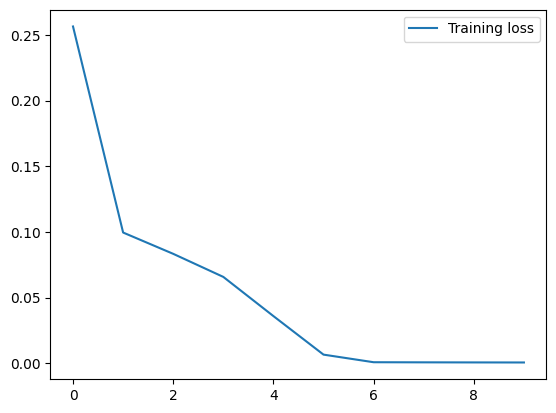

Test loss 0.0012544600758701563


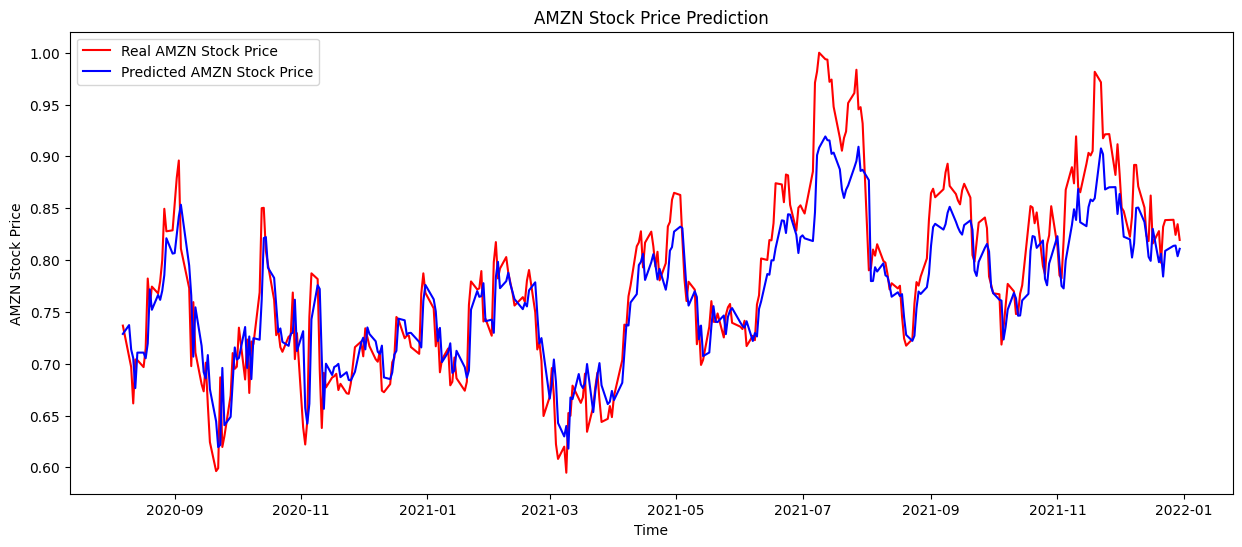

In [71]:
# vanilla rnn 1 hidden unit
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 10

model = Vanilla_RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('lstm 1 hidden unit',hist))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)


In [74]:
# vanilla rnn 32 hidden units

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = Vanilla_RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)




Epoch  0 MSE:  0.015099192787096804
Epoch  1 MSE:  0.0002021805567488223
Epoch  2 MSE:  0.00027430025440682785
Epoch  3 MSE:  0.00018482217329720798
Epoch  4 MSE:  0.00019736928551436803
Epoch  5 MSE:  0.0002290376179037897
Epoch  6 MSE:  0.0002503144483954303
Epoch  7 MSE:  0.00023774840244388743
Epoch  8 MSE:  0.00024248772711467205
Epoch  9 MSE:  0.0002440946179073459
Training time: 2.2817001342773438


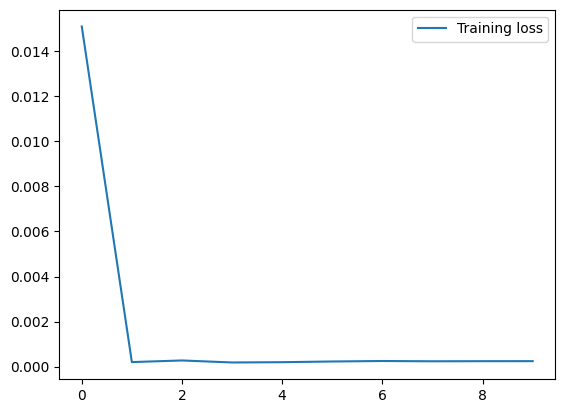

Test loss 0.0010099336504936218


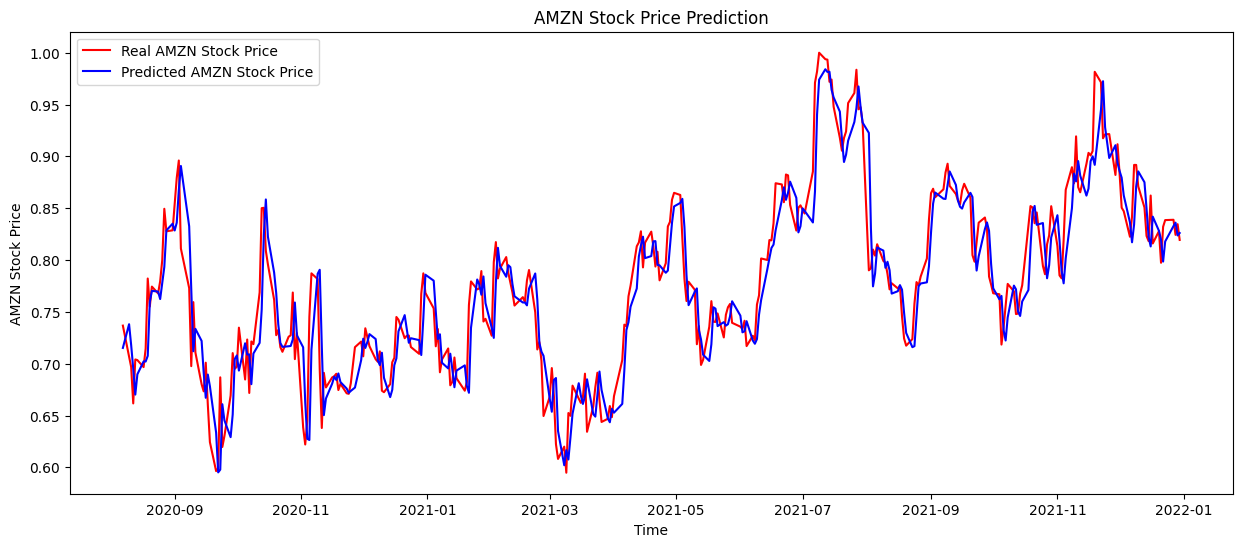

In [75]:
hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('lstm 32 hidden units', hist))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.35906147718843484
Epoch  1 MSE:  0.10391079748256339
Epoch  2 MSE:  0.07283062073919508
Epoch  3 MSE:  0.014469454187848087
Epoch  4 MSE:  0.0005581875854356136
Epoch  5 MSE:  0.00040892074998232094
Epoch  6 MSE:  0.00044491816515801474
Epoch  7 MSE:  0.0009798317074051334
Epoch  8 MSE:  0.0004728803397584771
Epoch  9 MSE:  0.0005905972537018695
Training time: 4.0640411376953125


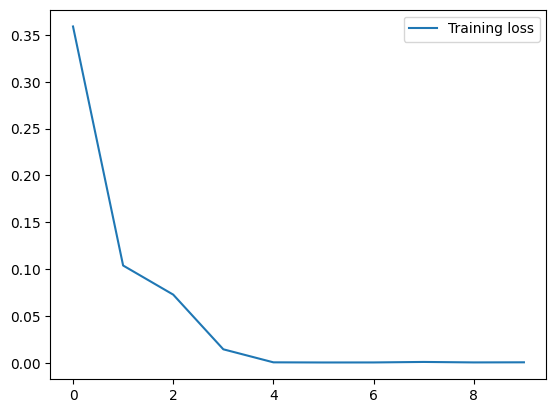

Test loss 0.0012015321990475059


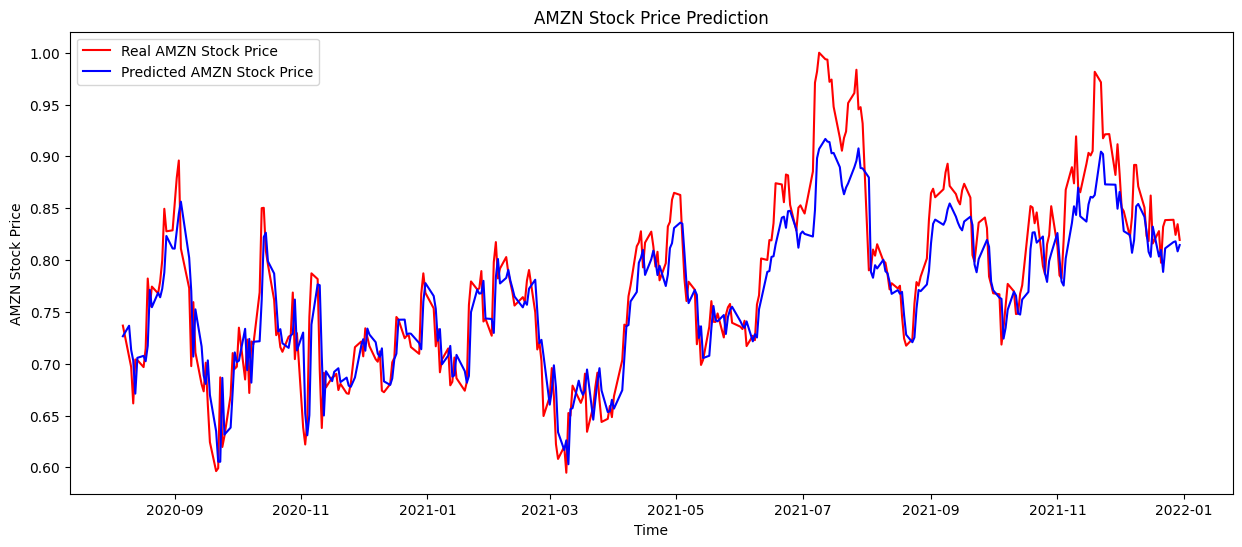

In [76]:
# rnn with 128 hidden units
input_dim = 1
hidden_dim = 128
num_layers = 1
output_dim = 1
num_epochs = 10

model = Vanilla_RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('lstm 128 hidden units',hist))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

In [15]:
loss_curves

[('lstm',
  array([1.37723709e-01, 3.71596523e-02, 2.53058706e-02, 1.40802359e-02,
         3.30969894e-03, 1.34021176e-04, 5.89551474e-05, 5.83645348e-05,
         5.79308262e-05, 5.68551584e-05])),
 ('lstm 32 hidden units',
  array([5.12460939e-03, 6.90543637e-05, 6.61609910e-05, 5.96935969e-05,
         6.30493446e-05, 6.89276358e-05, 7.56462607e-05, 5.74286398e-05,
         6.27342374e-05, 8.17608973e-05]))]

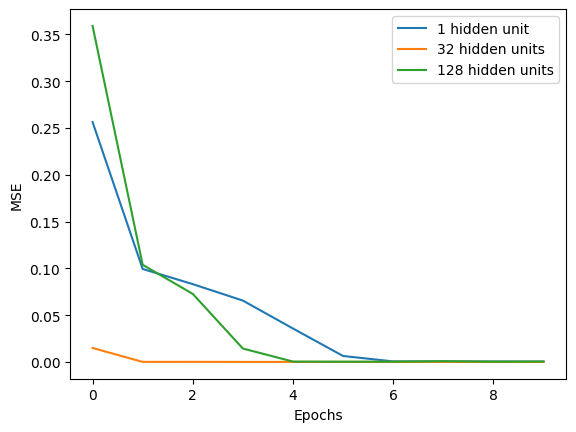

In [86]:
# rnn loss curves
# for x,y in loss_curves:
plt.plot(loss_curves[1][1], label=loss_curves[1][0][5:])
plt.plot(loss_curves[3][1], label=loss_curves[3][0][5:])
plt.plot(loss_curves[4][1], label=loss_curves[4][0][5:])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [87]:
rnn_vanilla_losses = loss_curves
loss_curves = []

Epoch  0 MSE:  0.020203908188401936
Epoch  1 MSE:  0.00022048336157038447
Epoch  2 MSE:  0.00017777860673757258
Epoch  3 MSE:  0.00025491292419448856
Epoch  4 MSE:  0.0002052626868539341
Epoch  5 MSE:  0.00020767517586743148
Epoch  6 MSE:  0.00017130144346487618
Epoch  7 MSE:  0.00020348273182611997
Epoch  8 MSE:  0.0001950701413180569
Epoch  9 MSE:  0.00021545196447429285
Training time: 4.261130094528198


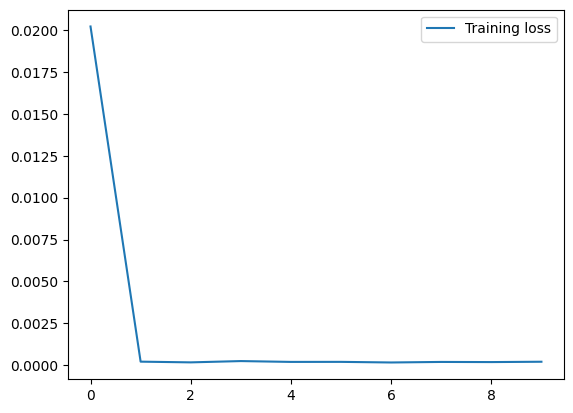

Test loss 0.0008933739154599607


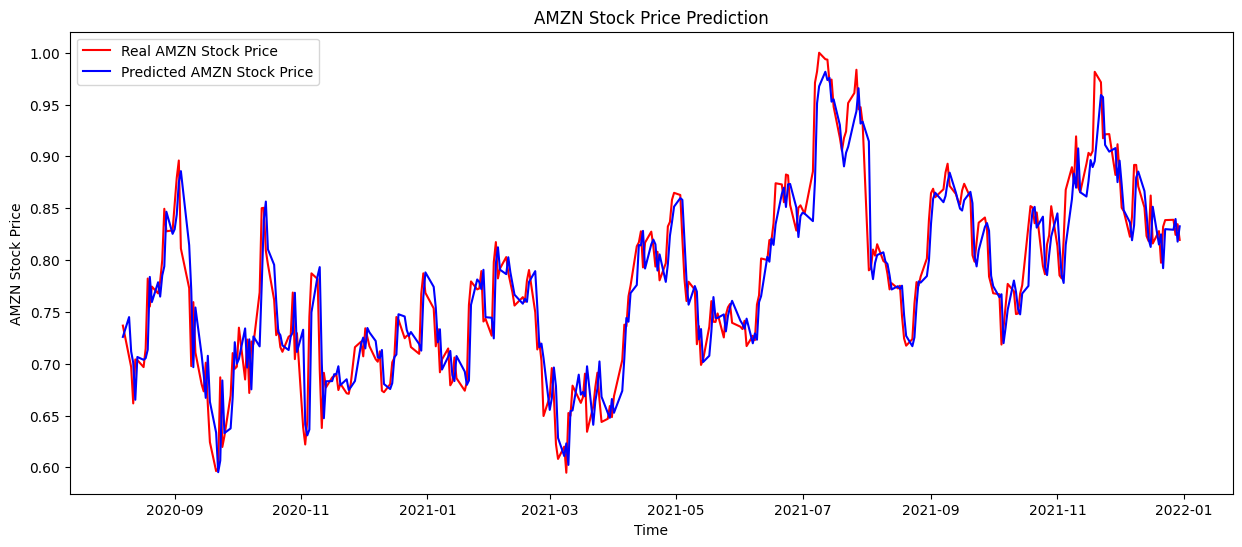

In [88]:
# stacked rnn
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('2 RNN layers',hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.027827108606490784
Epoch  1 MSE:  0.0003546833633865592
Epoch  2 MSE:  0.0005050858829539114
Epoch  3 MSE:  0.0003698217114005173
Epoch  4 MSE:  0.0003260456938834169
Epoch  5 MSE:  0.00045612020196333306
Epoch  6 MSE:  0.0003314831214488044
Epoch  7 MSE:  0.0002978631446239888
Epoch  8 MSE:  0.00038923983268230385
Epoch  9 MSE:  0.0003354883699810469
Training time: 8.392282009124756


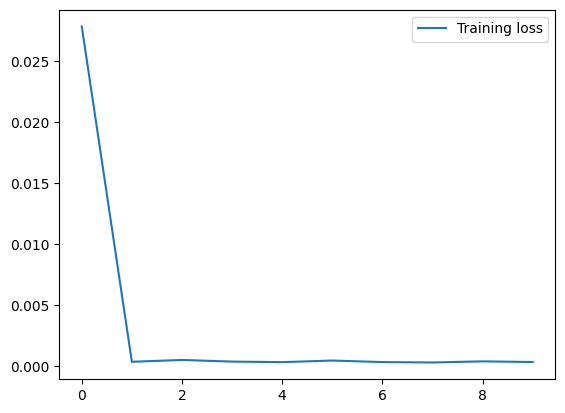

Test loss 0.0015033435774967074


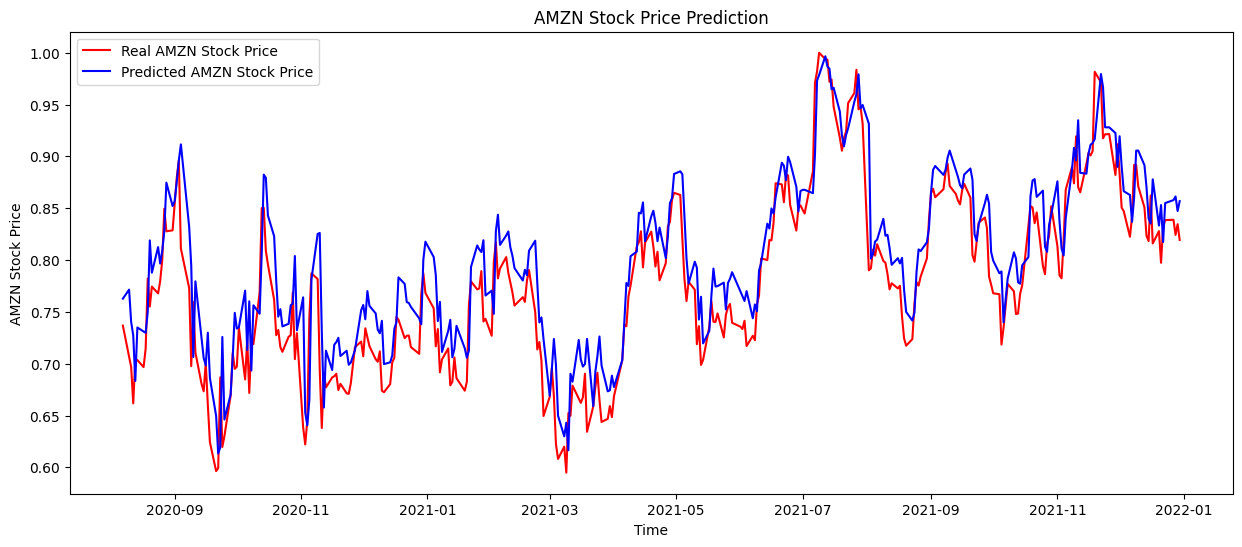

In [89]:
# stacked rnnn with 4 layers
input_dim = 1
hidden_dim = 32
num_layers = 4
output_dim = 1
num_epochs = 10

model = RNN(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('4 RNN layers',hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

In [90]:
stacked_rnn_loss = loss_curves
loss_curves=[]

Epoch  0 MSE:  0.01696878500762169
Epoch  1 MSE:  0.00020641650017852144
Epoch  2 MSE:  0.00020322891608278346
Epoch  3 MSE:  0.00020482702701782627
Epoch  4 MSE:  0.00021310441382461754
Epoch  5 MSE:  0.00023493157848659193
Epoch  6 MSE:  0.00024631208622041513
Epoch  7 MSE:  0.00017017947321088892
Epoch  8 MSE:  0.00020755221132478456
Epoch  9 MSE:  0.0002799335056301465
Training time: 8.58707880973816


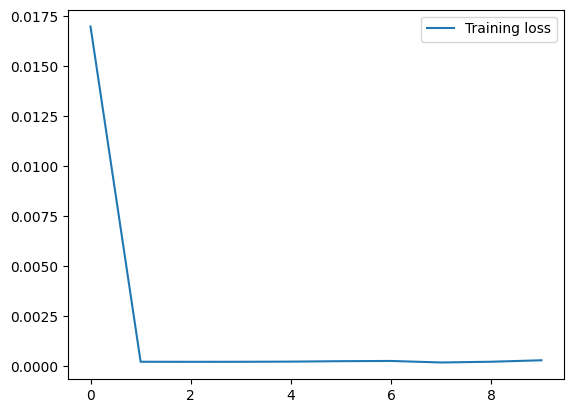

Test loss 0.0010792092652991414


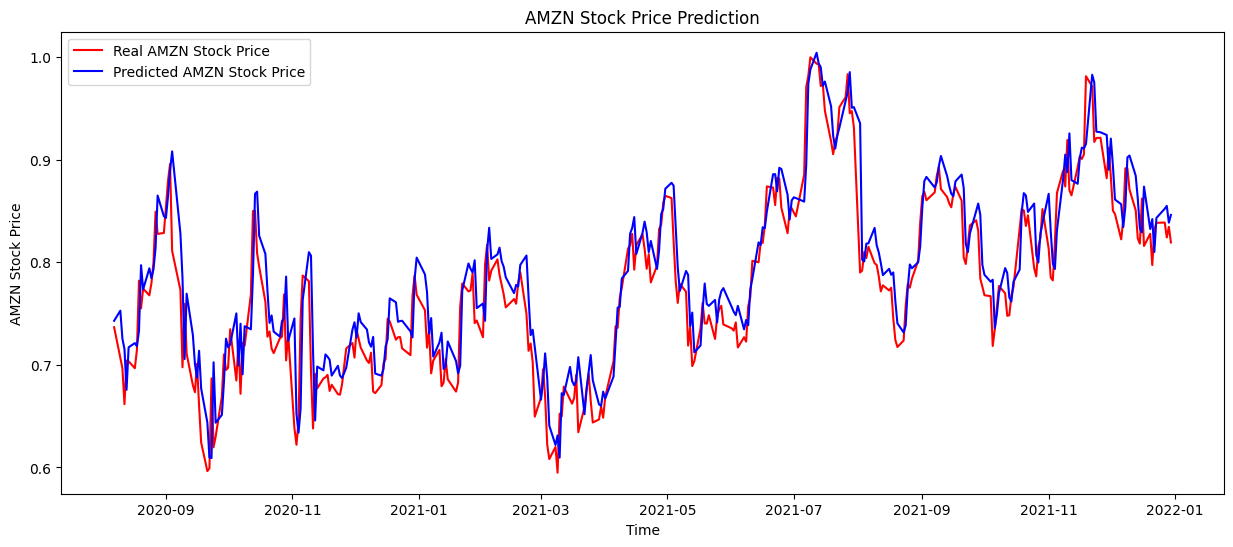

In [91]:
# bi directional rnn
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = RNN_bi(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('Bi RNN',hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

evaluate(model, dataset_close, X_test, y_test)

### LSTM

Epoch  0 MSE:  0.22442436766707236
Epoch  1 MSE:  0.090358291959597
Epoch  2 MSE:  0.0662329913272212
Epoch  3 MSE:  0.012124396482249722
Epoch  4 MSE:  0.0033234826696570963
Epoch  5 MSE:  0.0016717178465720888
Epoch  6 MSE:  0.000981725643416414
Epoch  7 MSE:  0.0006226568990920592
Epoch  8 MSE:  0.00046342903644674353
Epoch  9 MSE:  0.00038104071649690415
Training time: 3.832648992538452


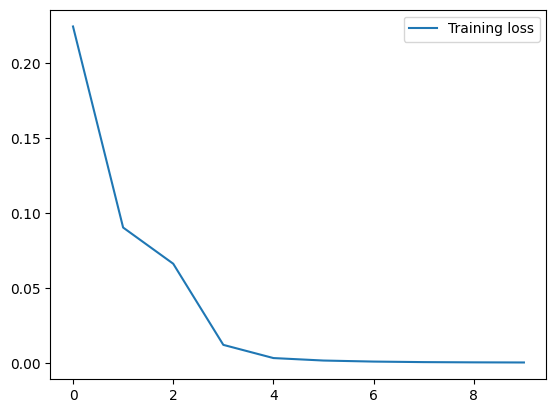

Test loss 0.0016109005082398653


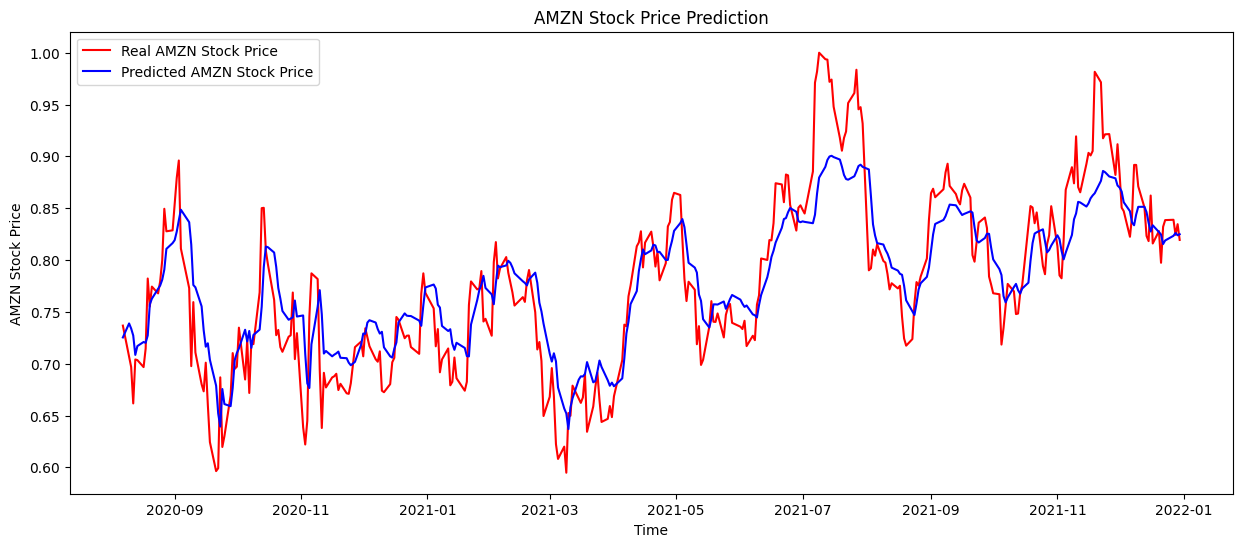

In [92]:
# vanilla lstm
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('lstm 1 hidden unit',hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.012203044690169109
Epoch  1 MSE:  0.00028634552018047543
Epoch  2 MSE:  0.0003976787407332773
Epoch  3 MSE:  0.0002683831318487743
Epoch  4 MSE:  0.00024016349172800093
Epoch  5 MSE:  0.0002688448749823793
Epoch  6 MSE:  0.00025495664097737364
Epoch  7 MSE:  0.00023718075585242736
Epoch  8 MSE:  0.00028048084565549897
Epoch  9 MSE:  0.0003394438127139034
Training time: 6.069086790084839


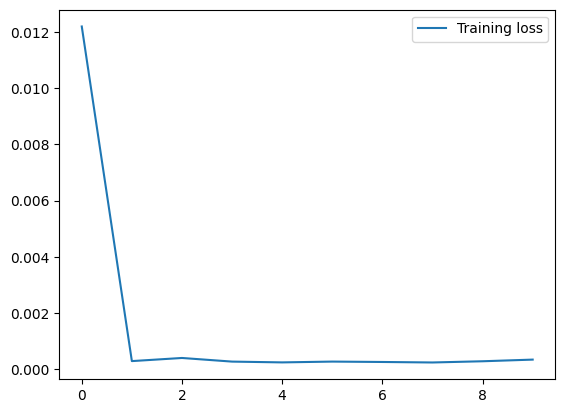

Test loss 0.001269824686460197


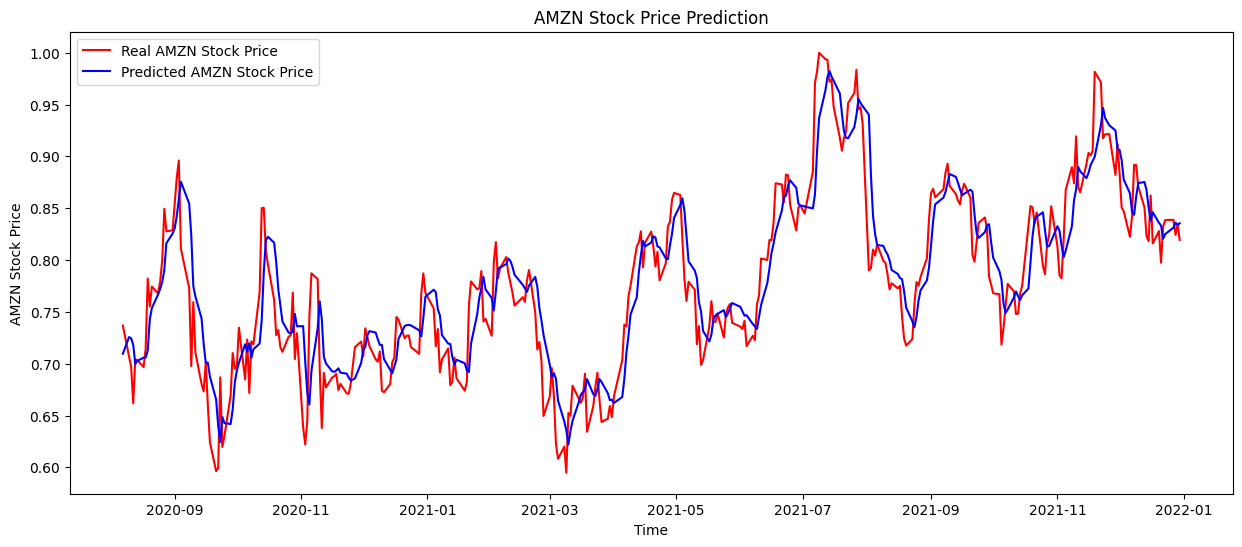

In [96]:
# lstm with 32 hidden units


input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('lstm 32 hidden units',hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.06928818285652799
Epoch  1 MSE:  0.000500771461399078
Epoch  2 MSE:  0.00025350985166975687
Epoch  3 MSE:  0.0002533121732994914
Epoch  4 MSE:  0.00027643964924411394
Epoch  5 MSE:  0.0002536804797980747
Epoch  6 MSE:  0.00025147736151767377
Epoch  7 MSE:  0.0003070897419092944
Epoch  8 MSE:  0.0002650502968006347
Epoch  9 MSE:  0.0002350568486993628
Training time: 15.452556133270264


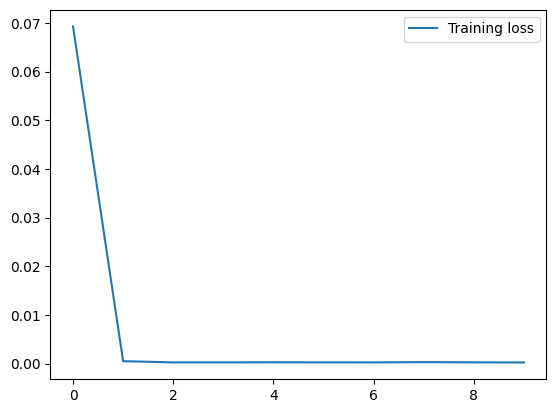

Test loss 0.001538854674436152


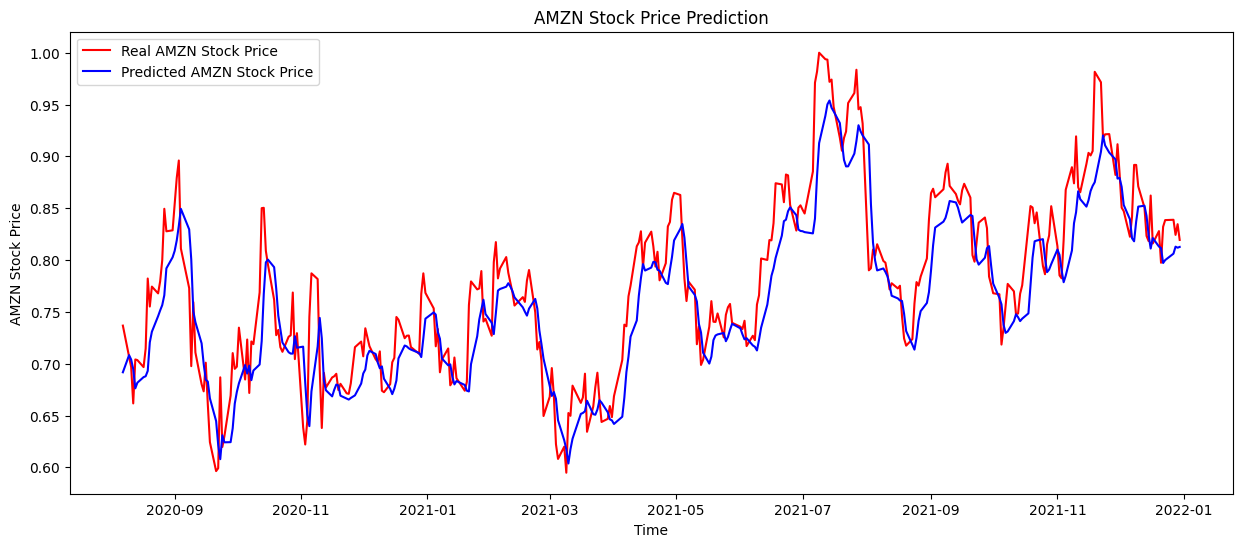

In [95]:
input_dim = 1
hidden_dim = 128
num_layers = 1
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('lstm 128 hidden units',hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

In [97]:
lstm_vanilla = loss_curves
loss_curves=[]

Epoch  0 MSE:  0.020188844186324988
Epoch  1 MSE:  0.0004896753824949781
Epoch  2 MSE:  0.0004118785860151143
Epoch  3 MSE:  0.0003670377387202785
Epoch  4 MSE:  0.0003743605252061065
Epoch  5 MSE:  0.0004692789243058036
Epoch  6 MSE:  0.00046012861629504996
Epoch  7 MSE:  0.0002789498797331665
Epoch  8 MSE:  0.00034336113155101583
Epoch  9 MSE:  0.000322914993476944
Training time: 12.516246795654297


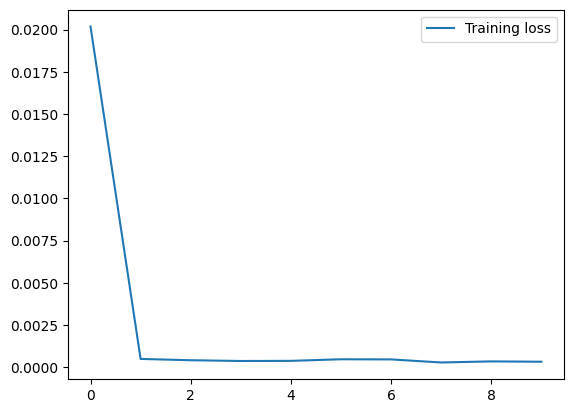

Test loss 0.001287995488382876


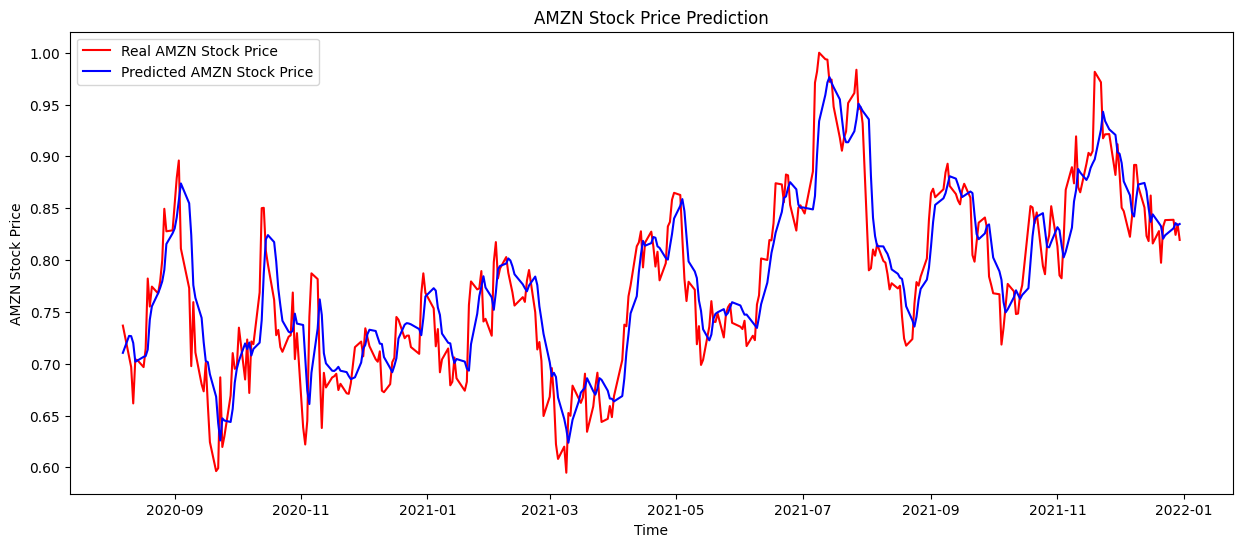

In [100]:
# stacked lstm 2 layers
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('2 LSTM layers', hist))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.06000011813658704
Epoch  1 MSE:  0.0013497363211677617
Epoch  2 MSE:  0.0004599203768723075
Epoch  3 MSE:  0.0004966715280008632
Epoch  4 MSE:  0.0005504997205005364
Epoch  5 MSE:  0.0003233683800216467
Epoch  6 MSE:  0.0002615200170971042
Epoch  7 MSE:  0.00032901695360326103
Epoch  8 MSE:  0.0003487696258667307
Epoch  9 MSE:  0.00033637452204655146
Training time: 24.846687078475952


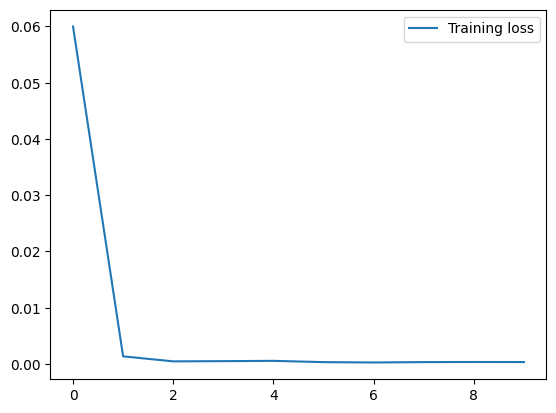

Test loss 0.0017694815760478377


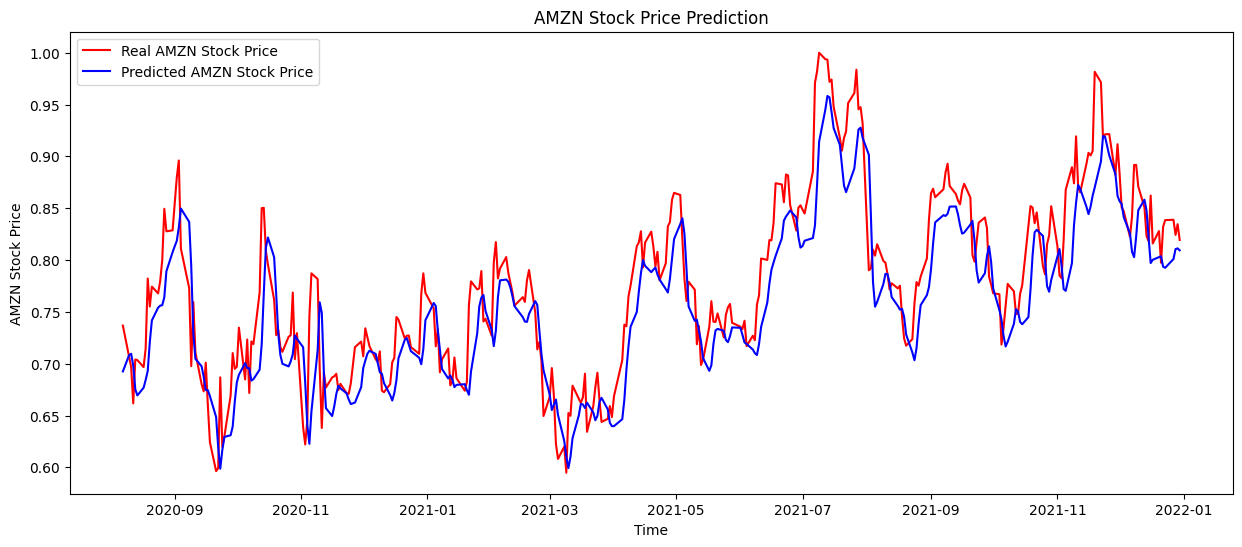

In [101]:
# stacked lstm 4 layers
input_dim = 1
hidden_dim = 32
num_layers = 4
output_dim = 1
num_epochs = 10

model = LSTM(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('4 LSTM layers', hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

In [102]:
lstm_stacked = loss_curves
loss_curves=[]

Epoch  0 MSE:  0.014739755389907967
Epoch  1 MSE:  0.00032622035031535133
Epoch  2 MSE:  0.00029436831133959157
Epoch  3 MSE:  0.00038653849514957983
Epoch  4 MSE:  0.00023020506058754917
Epoch  5 MSE:  0.00022416429166898725
Epoch  6 MSE:  0.00023896967109572465
Epoch  7 MSE:  0.00020297120661578246
Epoch  8 MSE:  0.0002372978661292614
Epoch  9 MSE:  0.0001940849915121766
Training time: 26.46100401878357


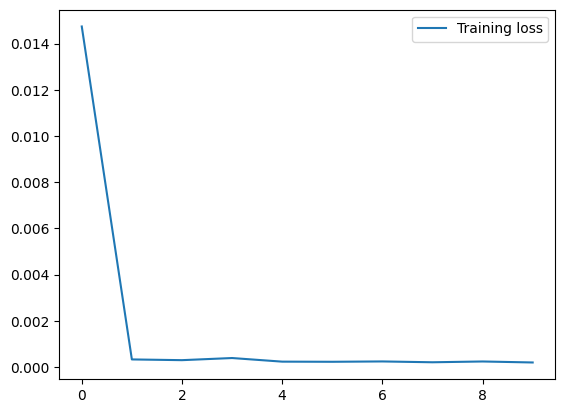

Test loss 0.001640015165321529


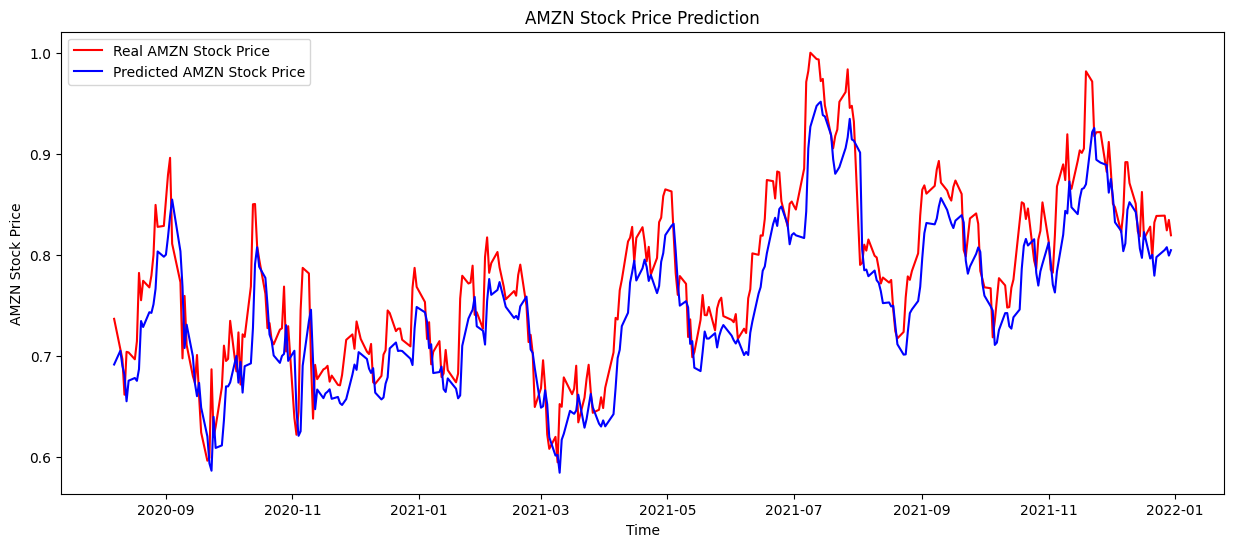

In [103]:
# lstm bidirectional
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = LSTM_v2(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('Bi LSTM', hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

In [104]:
bi_lstm = loss_curves
loss_curves=[]

### GRU

Epoch  0 MSE:  0.2768488213833835
Epoch  1 MSE:  0.11138260706017415
Epoch  2 MSE:  0.0928929151656727
Epoch  3 MSE:  0.0712713521077401
Epoch  4 MSE:  0.019379651272578888
Epoch  5 MSE:  0.0008335405319586345
Epoch  6 MSE:  0.0006087760939408327
Epoch  7 MSE:  0.0005153669278822943
Epoch  8 MSE:  0.00044014396553393453
Epoch  9 MSE:  0.00037470716779353097
Training time: 3.9906322956085205


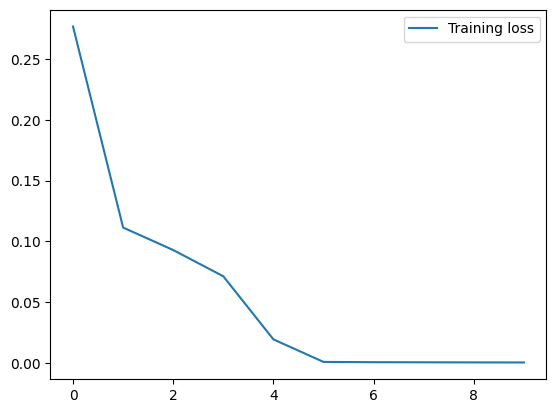

Test loss 0.0012598533648997545


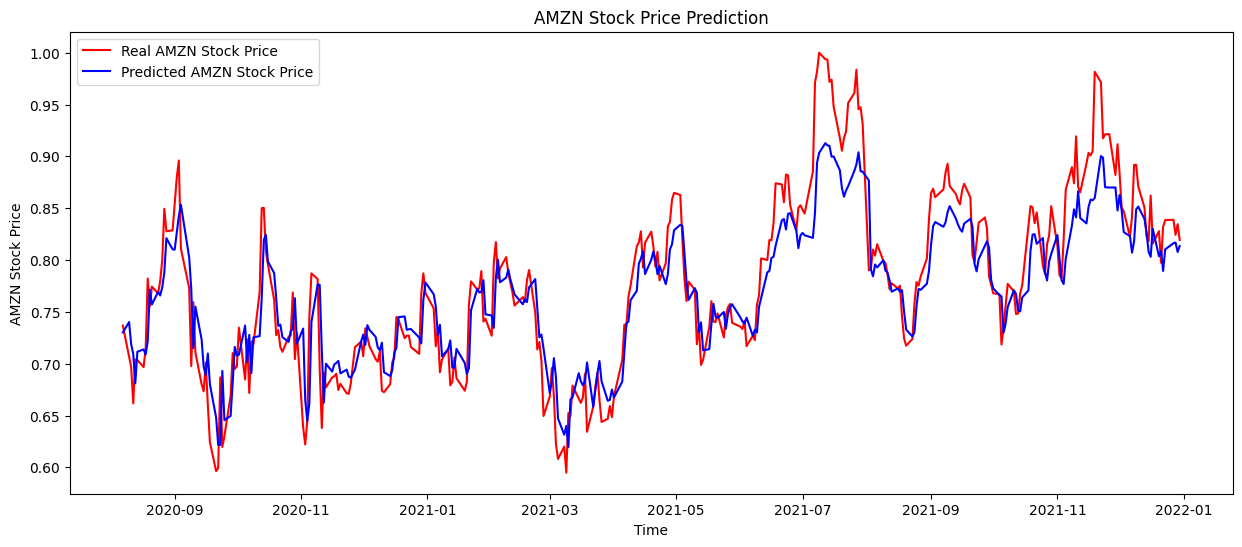

In [105]:
# vanilla gru
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('GRU 1 hidden units', hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.019317689049482095
Epoch  1 MSE:  0.00015887924127532137
Epoch  2 MSE:  0.00015009242899092592
Epoch  3 MSE:  0.00015131909444537287
Epoch  4 MSE:  0.00014130809485221916
Epoch  5 MSE:  0.0001676581315829632
Epoch  6 MSE:  0.0001689515133244236
Epoch  7 MSE:  0.0001720417879419579
Epoch  8 MSE:  0.00015178101984424252
Epoch  9 MSE:  0.00014361513449835507
Training time: 5.923891305923462


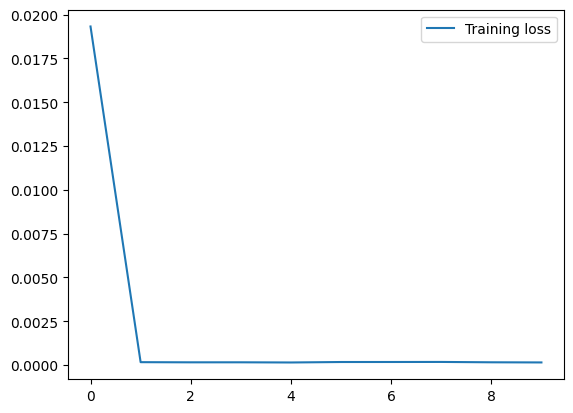

Test loss 0.0010149938752874732


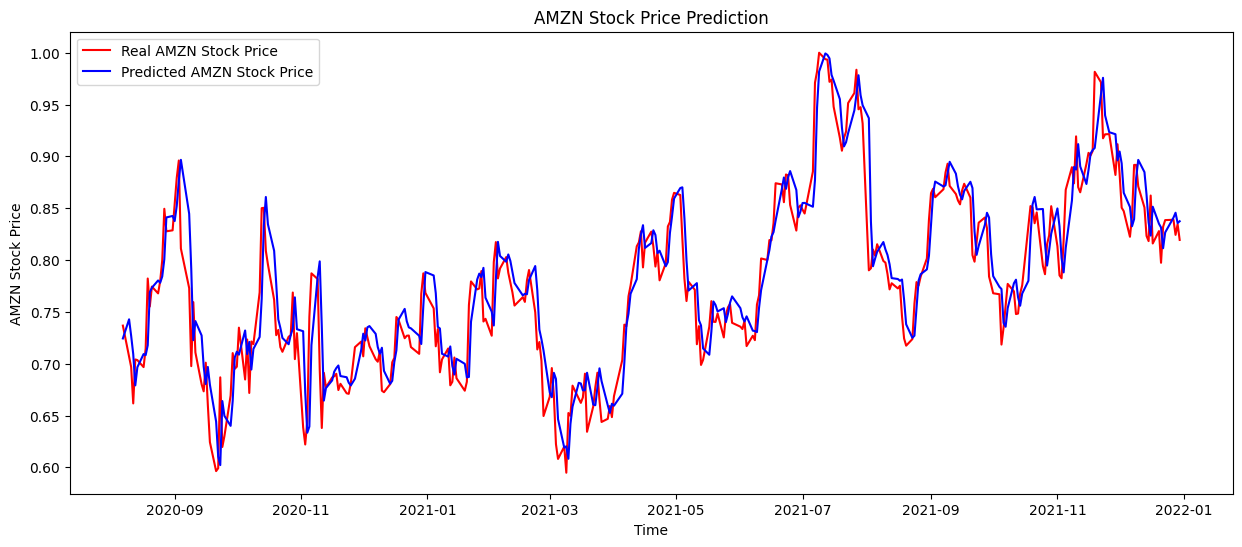

In [106]:
# gru with 32 hidd
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('GRU 32 hidden units', hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.016256034866273694
Epoch  1 MSE:  0.00015970076500101035
Epoch  2 MSE:  0.00013131089857173114
Epoch  3 MSE:  0.00013589656522425584
Epoch  4 MSE:  0.00014450660089298454
Epoch  5 MSE:  0.00015967212842345665
Epoch  6 MSE:  0.00014139695799207807
Epoch  7 MSE:  0.00015751995053708216
Epoch  8 MSE:  0.0001870616963009929
Epoch  9 MSE:  0.00013225044688169874
Training time: 12.330786228179932


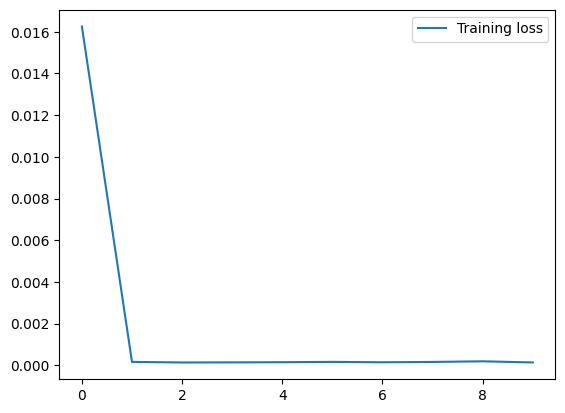

Test loss 0.0008853443432599306


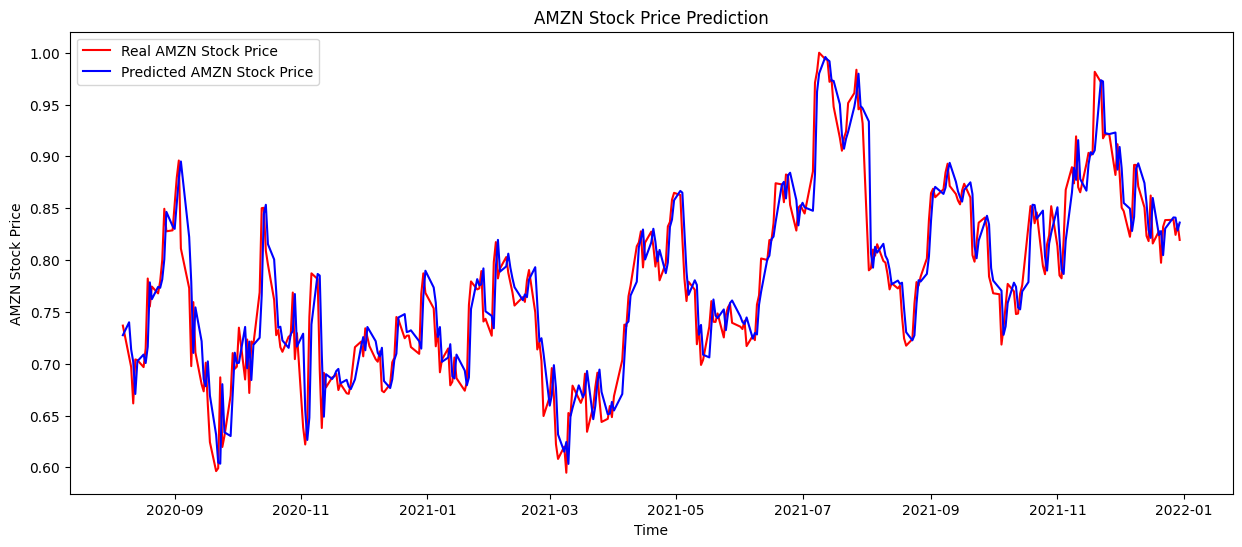

In [113]:
# gru with 128 hidd
input_dim = 1
hidden_dim = 128
num_layers = 1
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
# loss_curves.append(('GRU 128 hidden units', hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

In [108]:
vanilla_gru = loss_curves
loss_curves=[]

Epoch  0 MSE:  0.014284701732827266
Epoch  1 MSE:  0.00018252466017858952
Epoch  2 MSE:  0.00015976134439673237
Epoch  3 MSE:  0.0001863912534645351
Epoch  4 MSE:  0.0001955171084217808
Epoch  5 MSE:  0.00016662989497086123
Epoch  6 MSE:  0.00014323008900242308
Epoch  7 MSE:  0.00015900271301284697
Epoch  8 MSE:  0.00022952264235856192
Epoch  9 MSE:  0.00015128661865067747
Training time: 12.437839984893799


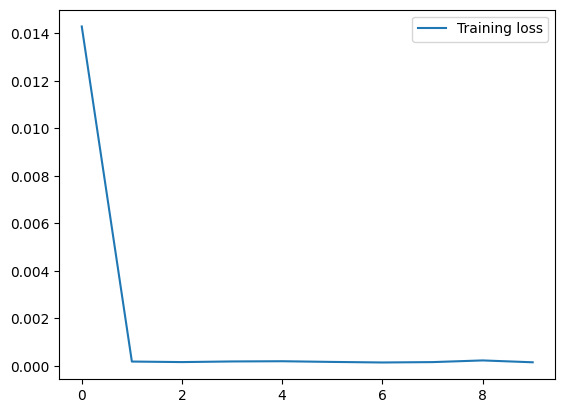

Test loss 0.000893798831384629


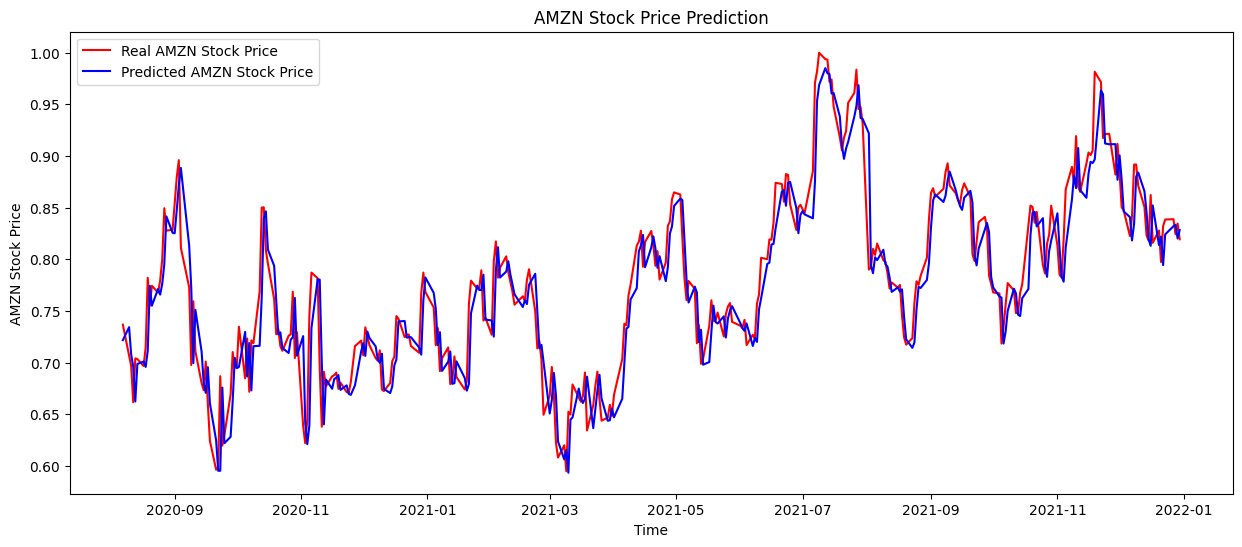

In [109]:
# gru with 2 stacked layers
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('GRU 2 layers', hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.020073047282494372
Epoch  1 MSE:  0.00045707435229916073
Epoch  2 MSE:  0.00043244560533316364
Epoch  3 MSE:  0.00032432292437079013
Epoch  4 MSE:  0.00023987114809642662
Epoch  5 MSE:  0.00029147461347949703
Epoch  6 MSE:  0.0005865372231205078
Epoch  7 MSE:  0.0002962937760963137
Epoch  8 MSE:  0.0004353187818095547
Epoch  9 MSE:  0.0003089981313072106
Training time: 24.92498803138733


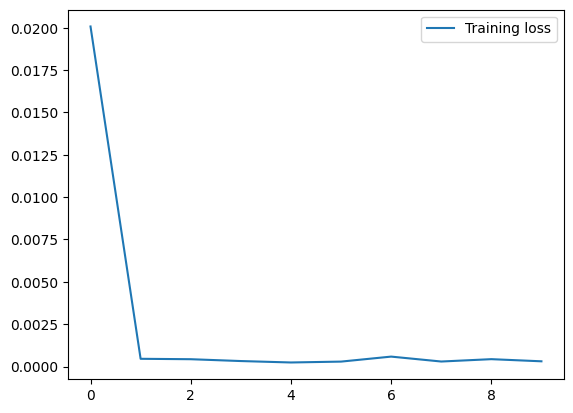

Test loss 0.001082417438738048


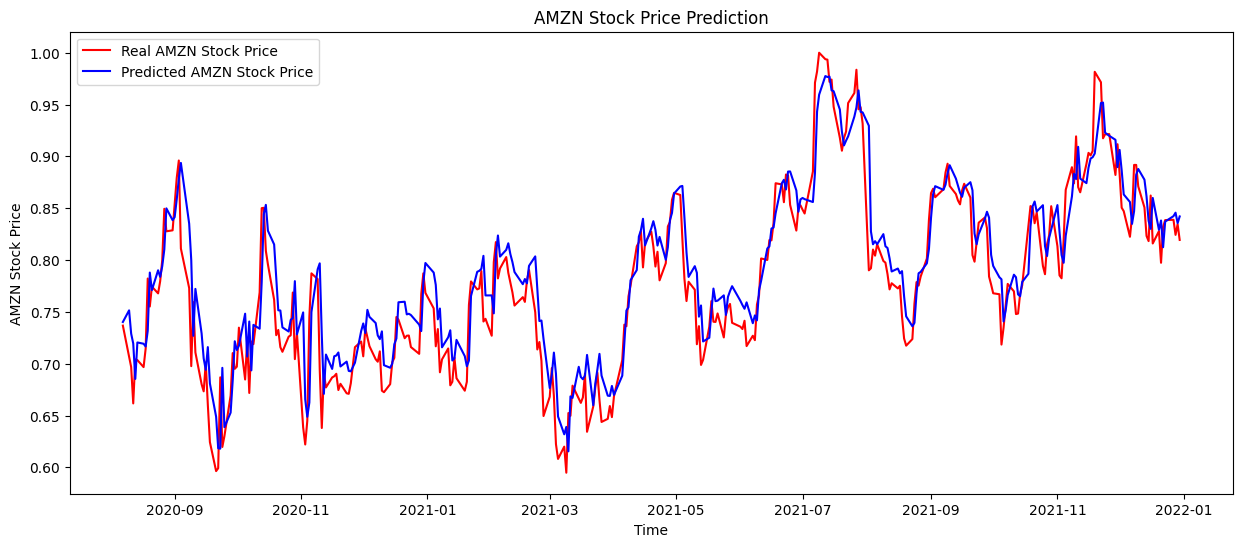

In [110]:
# gru with 4 stacked layers
input_dim = 1
hidden_dim = 32
num_layers = 4
output_dim = 1
num_epochs = 10

model = GRU(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('GRU 4 layers', hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

In [111]:
stacked_gru = loss_curves
loss_curves=[]

Epoch  0 MSE:  0.016190242396987742
Epoch  1 MSE:  0.00013605246269637265
Epoch  2 MSE:  0.00015173229222556175
Epoch  3 MSE:  0.00016390515720053777
Epoch  4 MSE:  0.0001572177541978211
Epoch  5 MSE:  0.00018716661192128312
Epoch  6 MSE:  0.00023620156240314018
Epoch  7 MSE:  0.00022453605091262338
Epoch  8 MSE:  0.00016188457594681595
Epoch  9 MSE:  0.00023364763463481117
Training time: 25.91634202003479


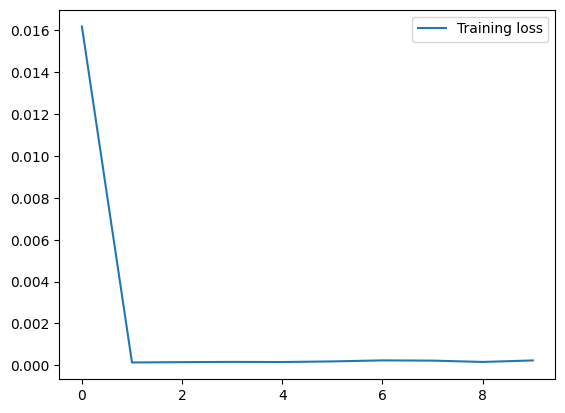

Test loss 0.0009001733851619065


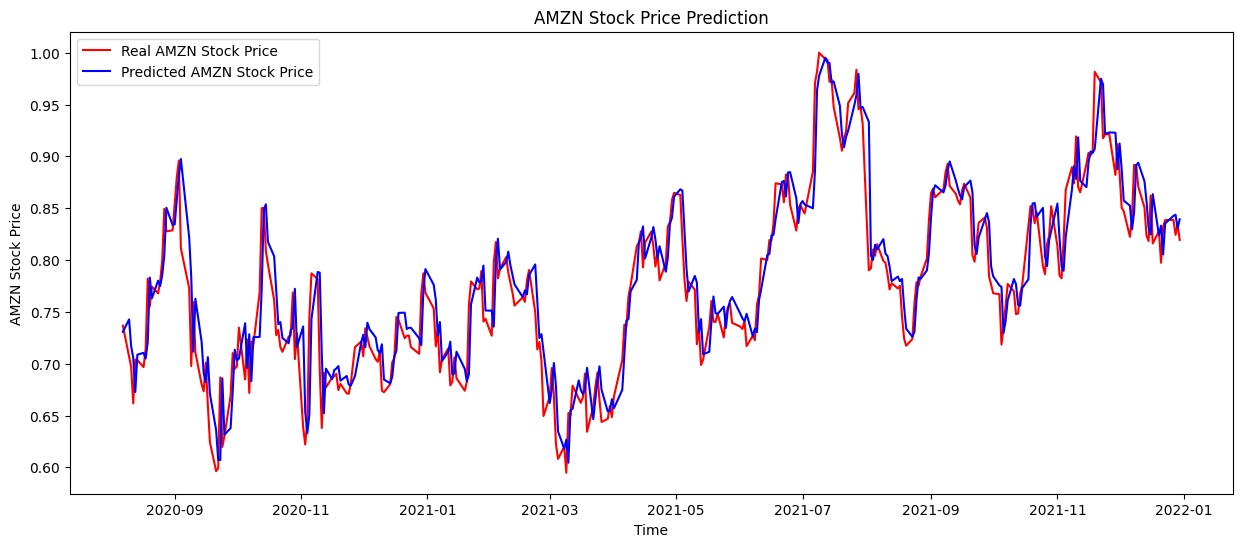

In [112]:
# bidirectional gru
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)
loss_curves.append(('Bi GRU', hist))

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

In [119]:
data_train_timestep = []
time_step = 200
# create all possible sequences of length look_back
for index in range(len(dataset_train_scaled) - time_step): 
    data_train_timestep.append(dataset_train_scaled[index: index + time_step])

data_train_timestep = np.array(data_train_timestep)
# test_timestamps = np.array(test_timestamps)

# test_size = int(np.round(0.2*data.shape[0]))
# train_size = data.shape[0] - (test_size)
# print(test_size)

X_train_timestep = data_train_timestep[:,:-1,:]
y_train_timestep = data_train_timestep[:,-1,:]

# X_test = data[train_size:,:-1]
# y_test = data[train_size:,-1,:]

# scale
# X_train = sc.fit_transform(X_train.reshape(-1,1))
# y_train = sc.fit_transform(y_train.reshape(-1,1))

# X_test = sc.fit_transform(X_test.reshape(-1,1))
# y_test = sc.fit_transform(y_test.reshape(-1,1))

data_test_timestep = []
# create all possible sequences of length look_back
for index in range(len(dataset_test_scaled) - time_step): 
    data_test_timestep.append(dataset_test_scaled[index: index + time_step])

data_test_timestep = np.array(data_test_timestep)


X_test_timestep = data_test_timestep[:,:-1]
y_test_timestep= data_test_timestep[:,-1,:]

X_train_timestep = torch.from_numpy(X_train_timestep).type(torch.Tensor)
y_train_timestep = torch.from_numpy(y_train_timestep).type(torch.Tensor)


X_test_timestep = torch.from_numpy(X_test_timestep).type(torch.Tensor)
y_test_timestep= torch.from_numpy(y_test_timestep).type(torch.Tensor)


train_ds_timestep = TensorDataset(X_train_timestep, y_train_timestep)
test_ds_timestep = TensorDataset(X_test_timestep, y_test_timestep)

batch_size = 24
train_dl_timestep = DataLoader(train_ds_timestep, batch_size, shuffle=True)
test_dl_timestep = DataLoader(test_ds_timestep, batch_size, shuffle=True)

Epoch  0 MSE:  0.008709971379199774
Epoch  1 MSE:  0.00020836839310408992
Epoch  2 MSE:  0.0002596042273628547
Epoch  3 MSE:  0.00016687129264506725
Epoch  4 MSE:  0.0002561797732835801
Epoch  5 MSE:  0.0002545003758314124
Epoch  6 MSE:  0.00030213342142815236
Epoch  7 MSE:  0.00023577088387882164
Epoch  8 MSE:  0.00019512453707791697
Epoch  9 MSE:  0.00017909601410792675
Training time: 2.5955300331115723


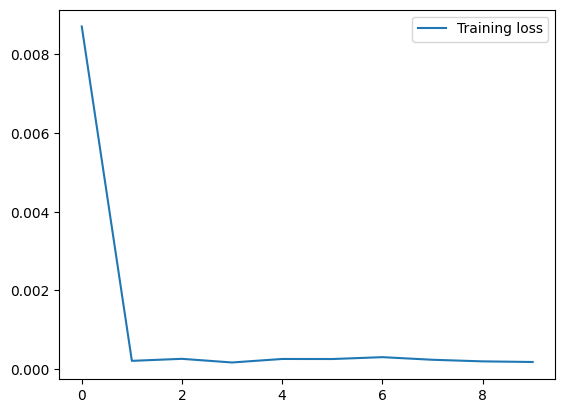

Test loss 0.0009692165185697377


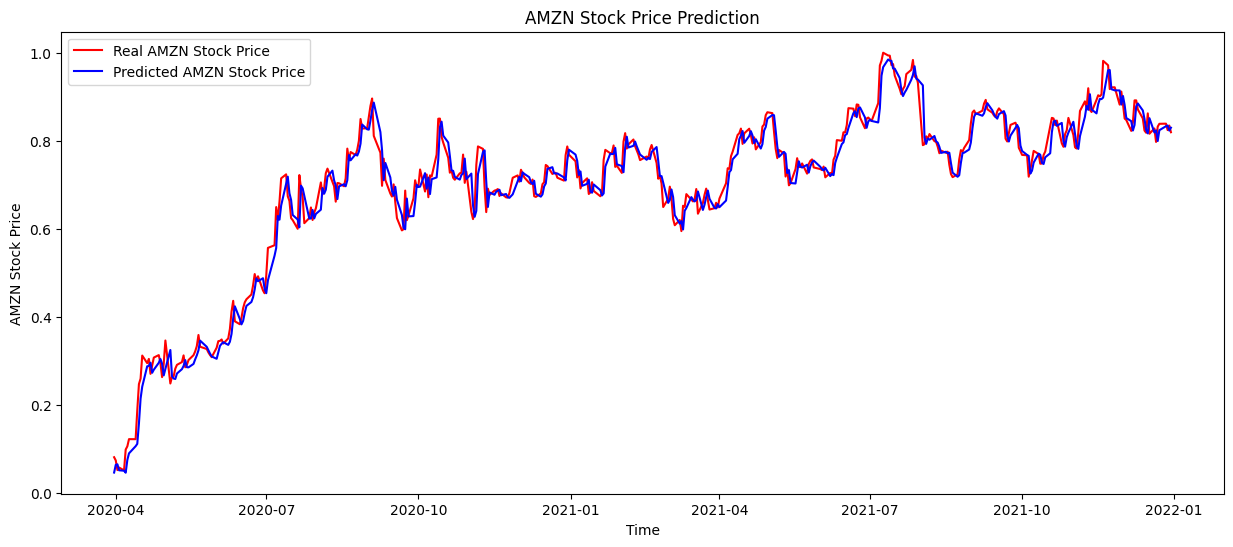

In [115]:
# GRU bidirectonal with 10 timestep
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl_timestep, model, criterion, optimiser)
loss_curves.append(('10 time steps', hist))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test_timestep, y_test_timestep)

Epoch  0 MSE:  0.007128246825182892
Epoch  1 MSE:  0.00022664887741042107
Epoch  2 MSE:  0.0002962008749228836
Epoch  3 MSE:  0.00024385263969707994
Epoch  4 MSE:  0.0002953288747301338
Epoch  5 MSE:  0.00023276536730181024
Epoch  6 MSE:  0.00025258907759495276
Epoch  7 MSE:  0.0002837621541525673
Epoch  8 MSE:  0.00047060720555384397
Epoch  9 MSE:  0.0002461034524654875
Training time: 13.228654146194458


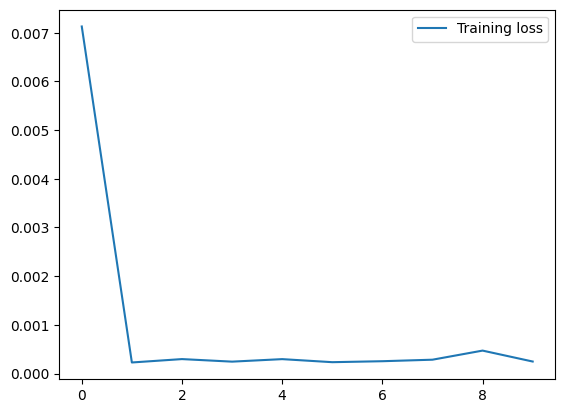

Test loss 0.000995200127363205


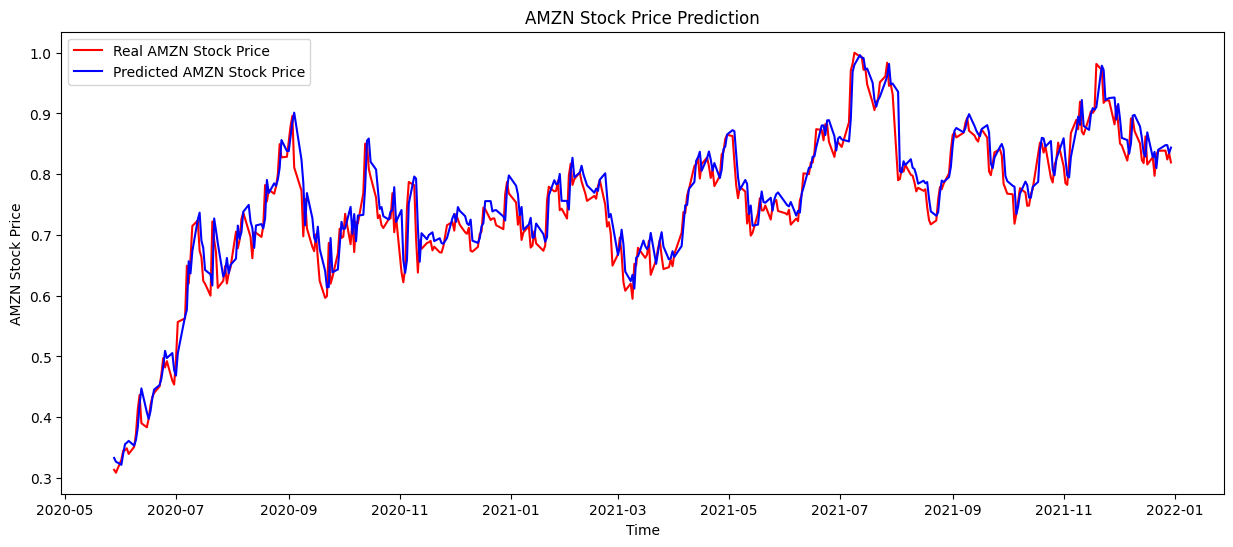

In [117]:
# GRU bidirectonal with 50 timestep
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl_timestep, model, criterion, optimiser)
loss_curves.append(('50 time steps', hist))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test_timestep, y_test_timestep)

Epoch  0 MSE:  0.01498388252896214
Epoch  1 MSE:  0.0001978955015682218
Epoch  2 MSE:  0.00019967588736215155
Epoch  3 MSE:  0.00019460939342132085
Epoch  4 MSE:  0.00016745686266136437
Epoch  5 MSE:  0.0001873084849969874
Epoch  6 MSE:  0.00023136972857387532
Epoch  7 MSE:  0.00032175945863641305
Epoch  8 MSE:  0.00015437507146784542
Epoch  9 MSE:  0.00029447276649400867
Training time: 48.600630044937134


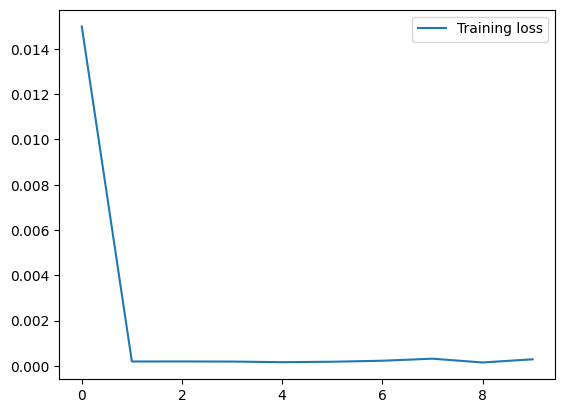

Test loss 0.0011407065903767943


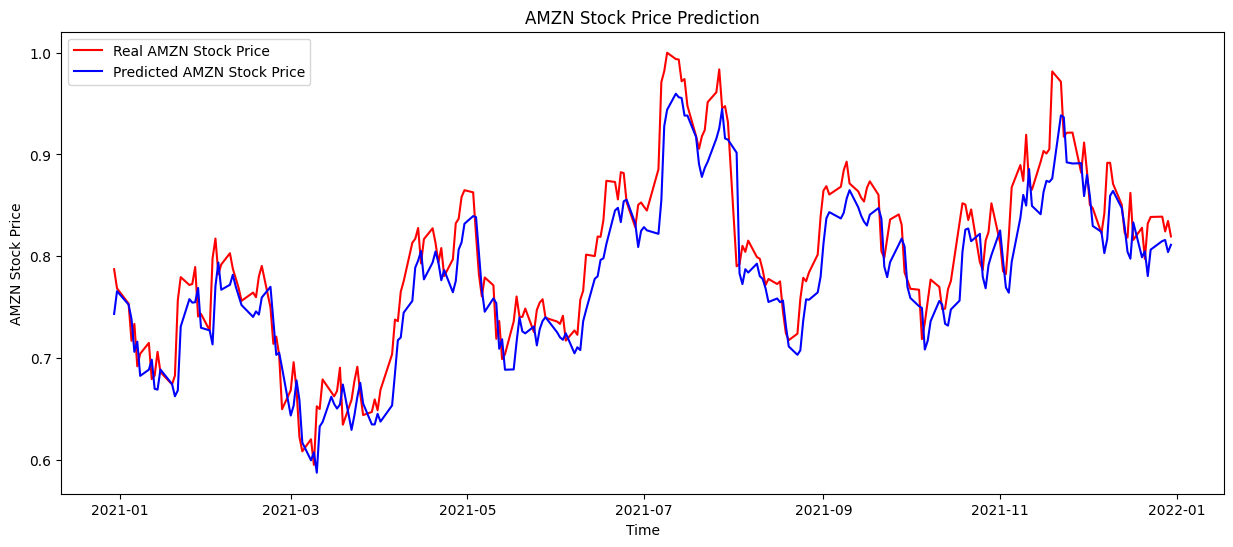

In [120]:
# GRU bidirectonal with 200 timestep
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl_timestep, model, criterion, optimiser)
loss_curves.append(('200 time steps', hist))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test_timestep, y_test_timestep)

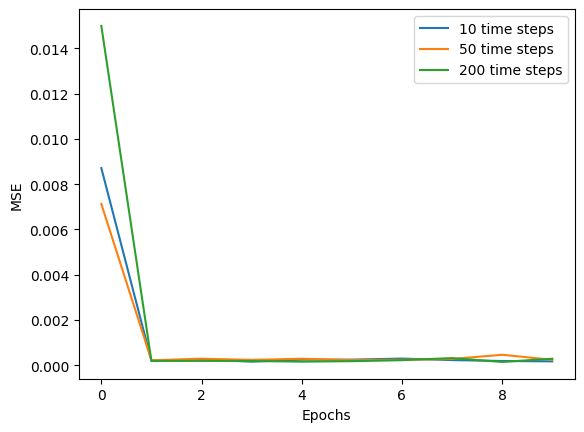

In [126]:
for x,y in loss_curves[1:]:
    plt.plot(y,label=x)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
plt.show()

Epoch  0 MSE:  0.04936152416808505
Epoch  1 MSE:  0.0002937902648025354
Epoch  2 MSE:  0.00022304719484762044
Epoch  3 MSE:  0.00020977880573506505
Epoch  4 MSE:  0.00021640688227206637
Epoch  5 MSE:  0.00020240538575914493
Epoch  6 MSE:  0.00019066899929182709
Epoch  7 MSE:  0.00018889527574275335
Epoch  8 MSE:  0.000189296776776852
Epoch  9 MSE:  0.0001821319131825779
Training time: 25.27747082710266


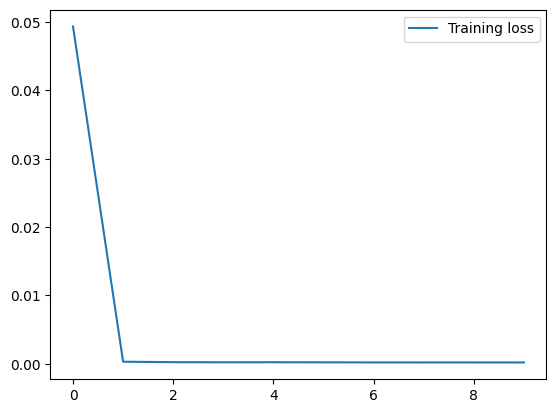

Test loss 0.0012082225875928998


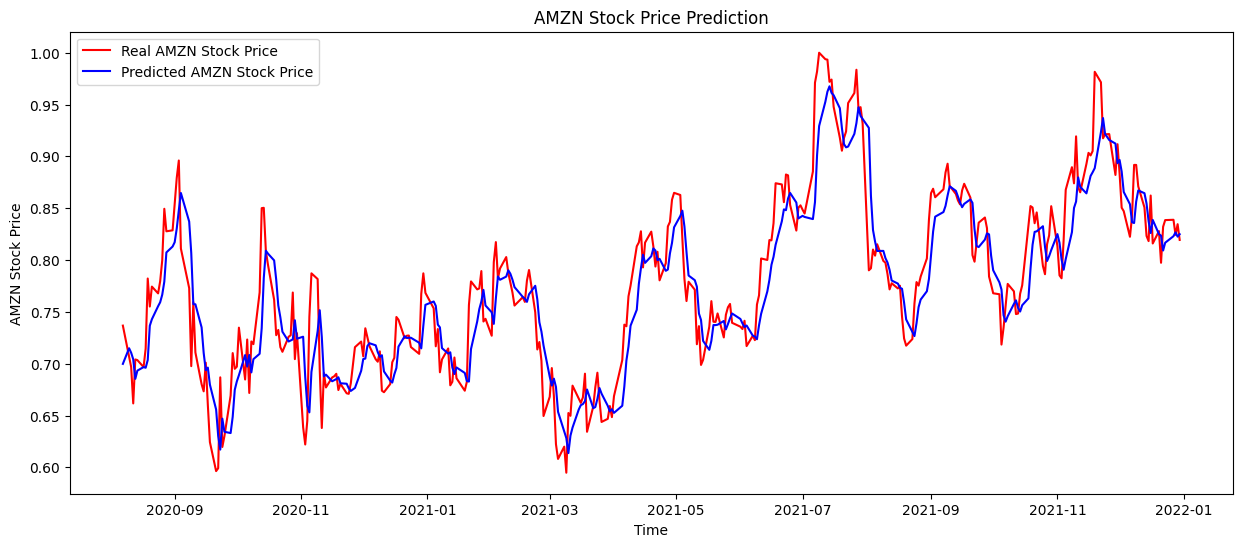

In [127]:
# GRU bidirectonal with 100 timestep, lower lr
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.4437284291780088
Epoch  1 MSE:  0.0017752318942964645
Epoch  2 MSE:  0.0010626929227631383
Epoch  3 MSE:  0.001336413148035515
Epoch  4 MSE:  0.0006711965357276818
Epoch  5 MSE:  0.0007489764113617841
Epoch  6 MSE:  0.0005003944208207637
Epoch  7 MSE:  0.0005019218022223666
Epoch  8 MSE:  0.0009893259648379171
Epoch  9 MSE:  0.0006857069236806032
Training time: 25.776978254318237


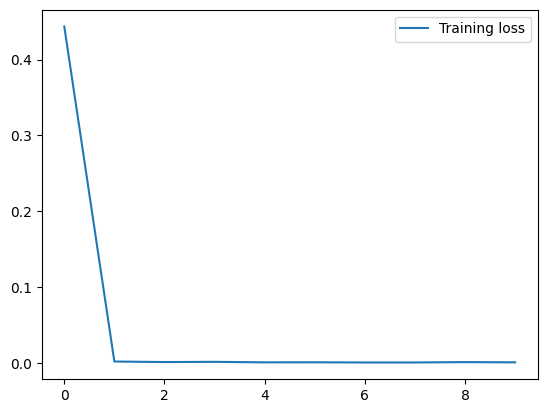

Test loss 0.0011334782466292381


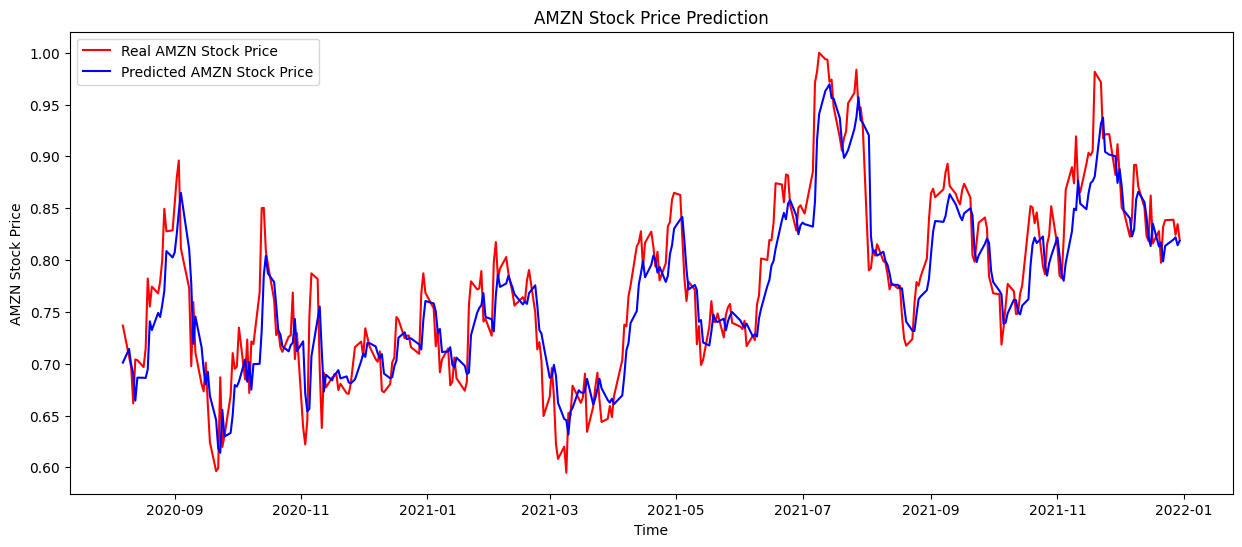

In [128]:
# GRU bidirectonal with 100 timestep, higher lr
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.010506220615095825
Epoch  1 MSE:  0.00016980484196614675
Epoch  2 MSE:  0.00019589246378220397
Epoch  3 MSE:  0.0001747158134245789
Epoch  4 MSE:  0.000176808339321926
Epoch  5 MSE:  0.00023793879864165824
Epoch  6 MSE:  0.0001757665199117279
Epoch  7 MSE:  0.00018074773841666078
Epoch  8 MSE:  0.0001650036215829055
Epoch  9 MSE:  0.00024233384162168173
Training time: 24.52408790588379


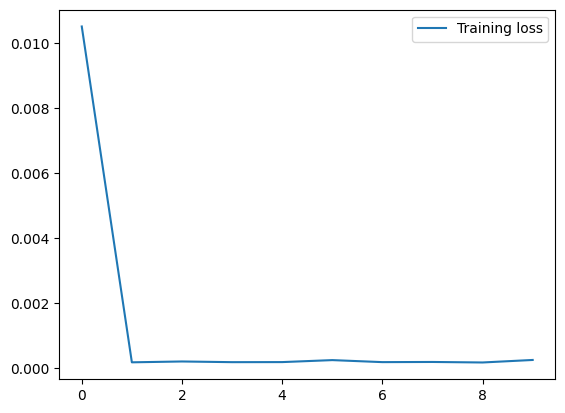

Test loss 0.0008940267143771052


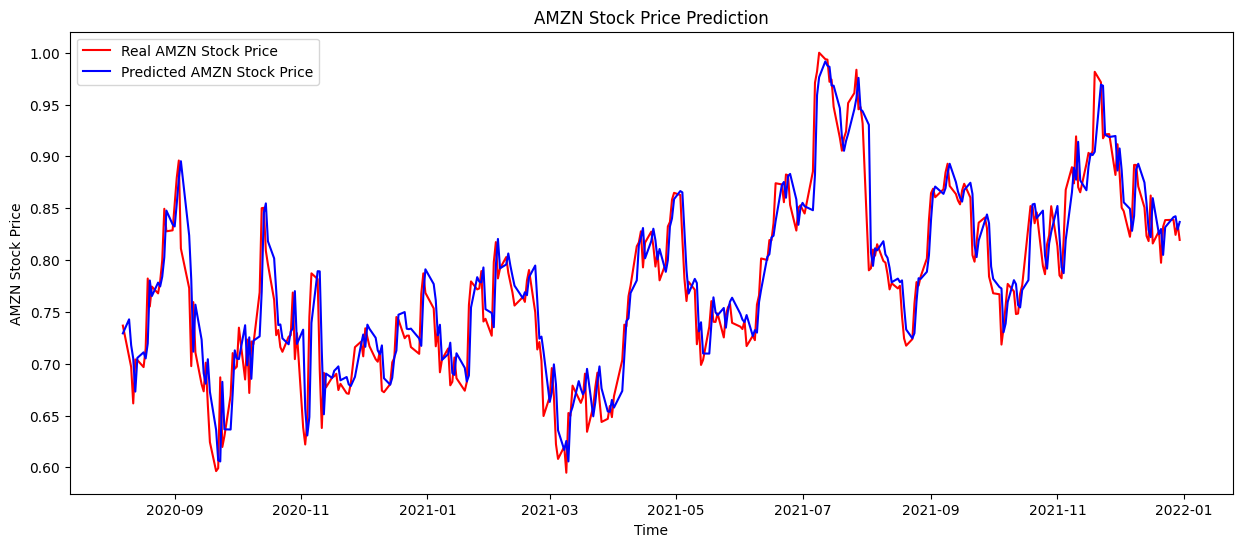

In [129]:
# GRU bidirectonal with 100 timestep , adamW and weight decay
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=4e-5)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

Epoch  0 MSE:  0.15831022895306684
Epoch  1 MSE:  0.005479080594442267
Epoch  2 MSE:  0.005365994509096102
Epoch  3 MSE:  0.004363725760211107
Epoch  4 MSE:  0.0051836816629575976
Epoch  5 MSE:  0.09917700544408742
Epoch  6 MSE:  0.045099313063676365
Epoch  7 MSE:  0.010079629923792608
Epoch  8 MSE:  0.018447616803718522
Epoch  9 MSE:  0.013993226935175093
Training time: 25.17104983329773


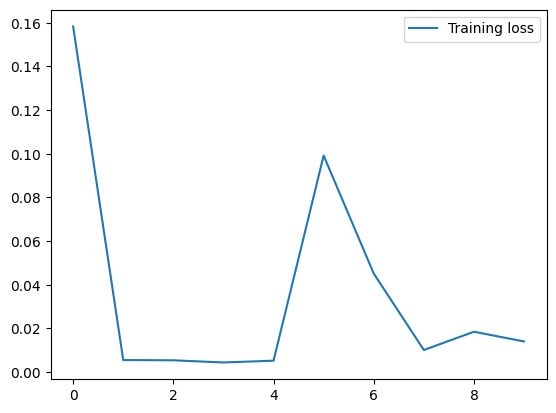

Test loss 0.004744004923850298


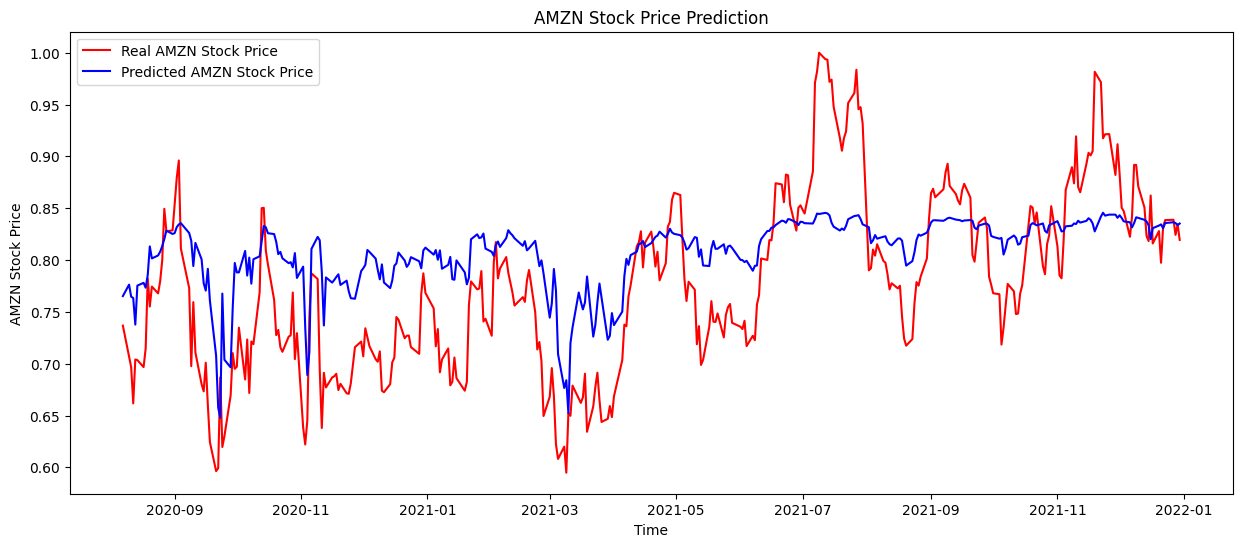

In [131]:
# GRU bidirectonal with 100 timestep , rmsporp
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.RMSprop(model.parameters())


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_close, X_test, y_test)

## Multivariate Time Series Forecasting

In [100]:
dataset_multi = dataset[['Open', 'High', 'Low', 'Close']]
dataset_multi

Open    High     Low   Close
Date                                      
2013-01-02   12.80   12.90   12.66   12.87
2013-01-03   12.86   13.04   12.82   12.92
2013-01-04   12.88   12.99   12.83   12.96
2013-01-07   13.15   13.49   13.13   13.42
2013-01-08   13.35   13.45   13.18   13.32
...            ...     ...     ...     ...
2021-12-23  170.43  171.98  170.15  171.07
2021-12-27  171.04  172.94  169.22  169.67
2021-12-28  170.18  172.18  169.14  170.66
2021-12-29  170.84  171.21  168.60  169.20
2021-12-30  169.70  170.89  168.52  168.64

[2266 rows x 4 columns]

In [101]:
sc = MinMaxScaler(feature_range=(0,1))
dataset_multi_scaled = sc.fit_transform(dataset_multi.values)

In [102]:
dataset_multi_scaled.shape

(2266, 4)

In [107]:
dataset_multi_scaled = np.array(dataset_multi_scaled)

data = []
time_step = 100
# create all possible sequences of length look_back
for index in range(len(dataset_multi_scaled) - time_step): 
    data.append(dataset_multi_scaled[index: index + time_step])

data = np.array(data)
# test_timestamps = np.array(test_timestamps)

test_size = int(np.round(0.2*data.shape[0]))
train_size = data.shape[0] - (test_size)
print(test_size)

X_train = data[:train_size,:-1,:]
y_train = data[:train_size,-1,-1].reshape(-1,1)

X_test = data[train_size:,:-1]
y_test = data[train_size:,-1,-1].reshape(-1,1)

433


In [108]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)


X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batch_size = 24
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [ ]:
y_test.shape

Epoch  0 MSE:  0.011649539209641149
Epoch  1 MSE:  6.245019789250912e-05
Epoch  2 MSE:  5.9610514903372496e-05
Epoch  3 MSE:  5.935465909316594e-05
Epoch  4 MSE:  5.924849373925149e-05
Epoch  5 MSE:  5.715029972833852e-05
Epoch  6 MSE:  5.9589122753245084e-05
Epoch  7 MSE:  5.84958022406918e-05
Epoch  8 MSE:  5.805686340278193e-05
Epoch  9 MSE:  7.280497393117937e-05
Epoch  10 MSE:  6.75965702113949e-05
Epoch  11 MSE:  7.405503820586066e-05
Epoch  12 MSE:  5.9102935192142514e-05
Epoch  13 MSE:  7.261483300033134e-05
Epoch  14 MSE:  5.660657426195852e-05
Epoch  15 MSE:  5.921500578302609e-05
Epoch  16 MSE:  5.991059574688273e-05
Epoch  17 MSE:  7.820044701263327e-05
Epoch  18 MSE:  7.315068587434338e-05
Epoch  19 MSE:  9.272592027104709e-05
Epoch  20 MSE:  7.824233879334428e-05
Epoch  21 MSE:  0.00010267777737407077
Epoch  22 MSE:  6.939097725641148e-05
Epoch  23 MSE:  7.77217011738984e-05
Epoch  24 MSE:  6.769409653677267e-05
Epoch  25 MSE:  9.838457511138324e-05
Epoch  26 MSE:  7.8758

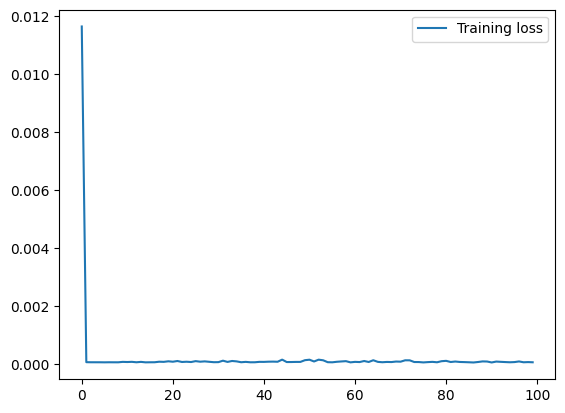

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.032050229609012604


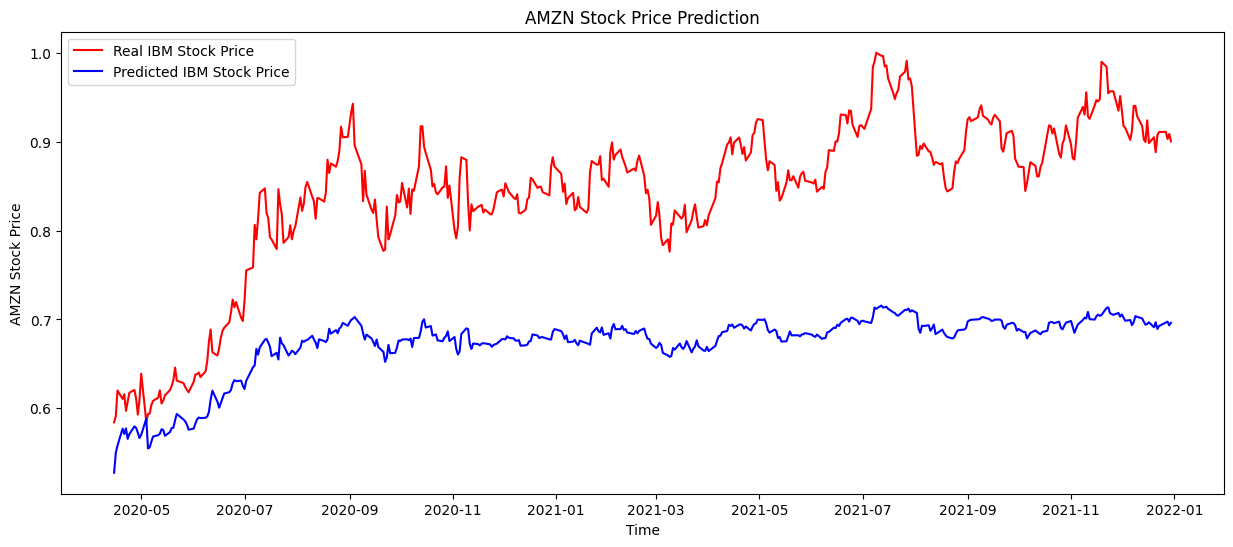

In [111]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = RNN_bi(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

Epoch  0 MSE:  0.0032664060643782414
Epoch  1 MSE:  0.00012122408216247057
Epoch  2 MSE:  7.627550384973827e-05
Epoch  3 MSE:  8.242173811445915e-05
Epoch  4 MSE:  7.485950882006389e-05
Epoch  5 MSE:  7.315093924960023e-05
Epoch  6 MSE:  7.387716583526862e-05
Epoch  7 MSE:  9.251279936182833e-05
Epoch  8 MSE:  0.00014718673222364174
Epoch  9 MSE:  7.340094442989626e-05
Epoch  10 MSE:  8.093587473000572e-05
Epoch  11 MSE:  6.630645829355759e-05
Epoch  12 MSE:  7.440068640964255e-05
Epoch  13 MSE:  0.00019676753797521335
Epoch  14 MSE:  7.277249789370977e-05
Epoch  15 MSE:  5.644128400926504e-05
Epoch  16 MSE:  9.018542171249203e-05
Epoch  17 MSE:  8.256661893850933e-05
Epoch  18 MSE:  6.243726600537417e-05
Epoch  19 MSE:  6.40965007645818e-05
Epoch  20 MSE:  7.318776237273234e-05
Epoch  21 MSE:  0.00010348039609509638
Epoch  22 MSE:  6.107419766808624e-05
Epoch  23 MSE:  7.525231497822137e-05
Epoch  24 MSE:  6.501617773297667e-05
Epoch  25 MSE:  6.334944195359267e-05
Epoch  26 MSE:  6.9

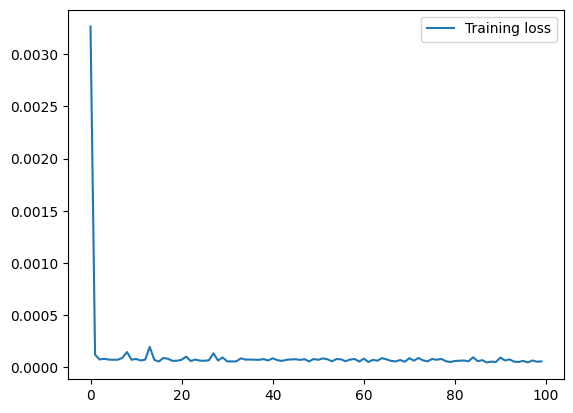

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.00854709092527628


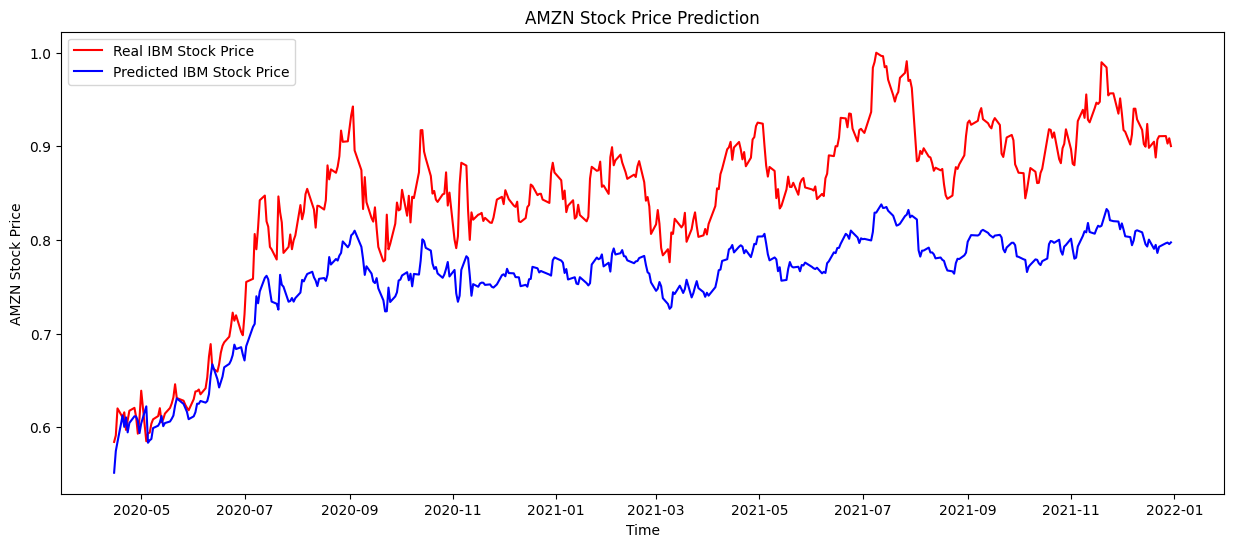

In [109]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM_v2(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

Epoch  0 MSE:  0.005275973133866999
Epoch  1 MSE:  7.144560724355708e-05
Epoch  2 MSE:  5.6803035576730545e-05
Epoch  3 MSE:  6.045451336582143e-05
Epoch  4 MSE:  5.9756090456786506e-05
Epoch  5 MSE:  7.86773492931488e-05
Epoch  6 MSE:  5.814162785112511e-05
Epoch  7 MSE:  8.920962188798736e-05
Epoch  8 MSE:  5.9760485957468355e-05
Epoch  9 MSE:  6.145281630069056e-05
Epoch  10 MSE:  6.0031236363064546e-05
Epoch  11 MSE:  6.471574781169518e-05
Epoch  12 MSE:  7.86478754790015e-05
Epoch  13 MSE:  6.767131402465229e-05
Epoch  14 MSE:  8.535453700261152e-05
Epoch  15 MSE:  7.048033946114018e-05
Epoch  16 MSE:  0.00011331220760950277
Epoch  17 MSE:  7.810191586380426e-05
Epoch  18 MSE:  6.337001219460397e-05
Epoch  19 MSE:  8.798368786575675e-05
Epoch  20 MSE:  0.0001304024817104681
Epoch  21 MSE:  7.80702487907248e-05
Epoch  22 MSE:  8.235151618427066e-05
Epoch  23 MSE:  0.00012045076836367203
Epoch  24 MSE:  0.00010139776948139339
Epoch  25 MSE:  7.843615535358828e-05
Epoch  26 MSE:  5.9

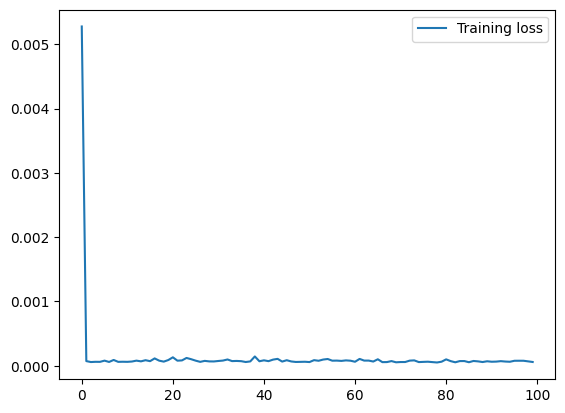

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.012409016489982605


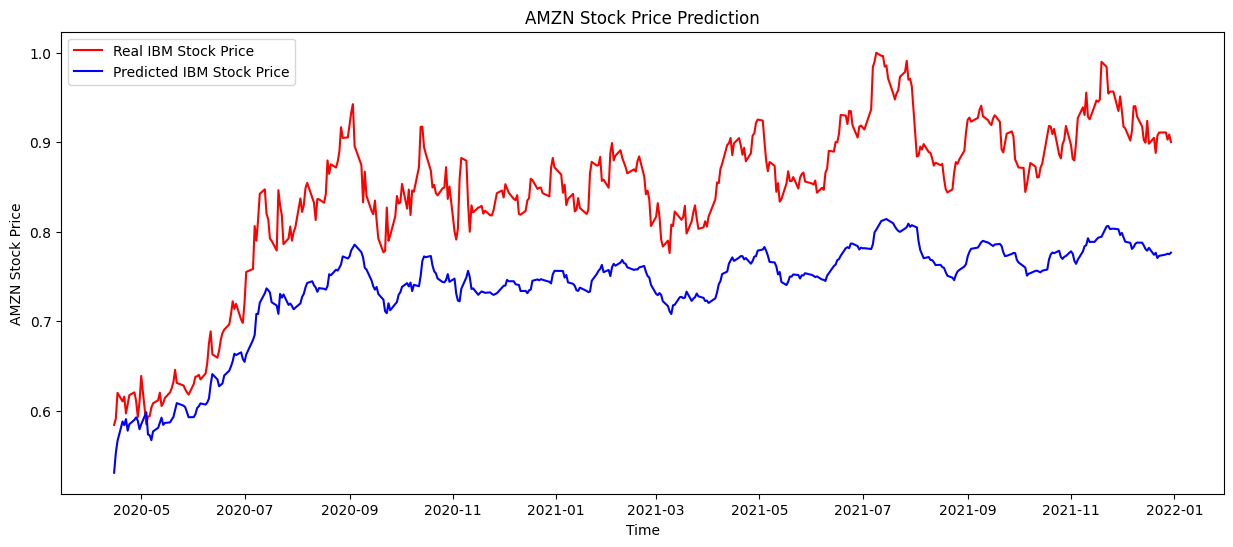

In [112]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

<AxesSubplot: xlabel='Date'>

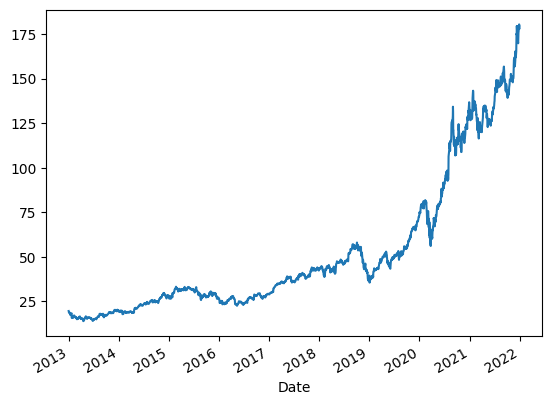

In [113]:
# getting all 4 company stocks
AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset_amzn = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
GOOG = yf.download('GOOG', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset_GOOG = GOOG[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
MSFT = yf.download('MSFT', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset_MSFT = MSFT[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
AAPL = yf.download('AAPL', 
                      start='2013-01-01', 
                      end='2021-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN')  
dataset_AAPL = AAPL[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
dataset_AAPL.head(10)
dataset_AAPL['Close'].plot()

In [124]:
dataset_amzn.rename(columns={'Close':'AMZN'},inplace=True)

dataset_close=dataset_amzn[['AMZN']]
dataset_close['GOOG']=dataset_GOOG['Close']
dataset_close['MSFT']=dataset_MSFT['Close']
dataset_close['AAPL']=dataset_AAPL['Close']
dataset_close

/var/folders/bk/sj8dwg9d73vb0r56r8k9md280000gn/T/ipykernel_35816/1315785748.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_close['GOOG']=dataset_GOOG['Close']
/var/folders/bk/sj8dwg9d73vb0r56r8k9md280000gn/T/ipykernel_35816/1315785748.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_close['MSFT']=dataset_MSFT['Close']
/var/folders/bk/sj8dwg9d73vb0r56r8k9md280000gn/T/ipykernel_35816/1315785748.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

AMZN    GOOG    MSFT    AAPL
Date                                      
2013-01-02   12.87   18.01   27.62   19.61
2013-01-03   12.92   18.02   27.25   19.36
2013-01-04   12.96   18.38   26.74   18.82
2013-01-07   13.42   18.30   26.69   18.71
2013-01-08   13.32   18.26   26.55   18.76
...            ...     ...     ...     ...
2021-12-23  171.07  147.14  334.69  176.28
2021-12-27  169.67  148.06  342.45  180.33
2021-12-28  170.66  146.45  341.25  179.29
2021-12-29  169.20  146.50  341.95  179.38
2021-12-30  168.64  146.00  339.32  178.20

[2266 rows x 4 columns]

In [125]:
sc = MinMaxScaler(feature_range=(0,1))
dataset_multi_scaled = sc.fit_transform(dataset_close.values)

In [126]:
dataset_multi_scaled = np.array(dataset_multi_scaled)

data = []
time_step = 100
# create all possible sequences of length look_back
for index in range(len(dataset_multi_scaled) - time_step): 
    data.append(dataset_multi_scaled[index: index + time_step])

data = np.array(data)
# test_timestamps = np.array(test_timestamps)

test_size = int(np.round(0.2*data.shape[0]))
train_size = data.shape[0] - (test_size)
print(test_size)

X_train = data[:train_size,:-1,:]
y_train = data[:train_size,-1,-1].reshape(-1,1)

X_test = data[train_size:,:-1]
y_test = data[train_size:,-1,-1].reshape(-1,1)

433


In [127]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)


X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batch_size = 24
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

Epoch  0 MSE:  0.007447440155274682
Epoch  1 MSE:  0.00037743153719531293
Epoch  2 MSE:  0.00010372543650578025
Epoch  3 MSE:  7.380827663251843e-05
Epoch  4 MSE:  6.202820089764491e-05
Epoch  5 MSE:  3.6715018206002105e-05
Epoch  6 MSE:  4.086466295320113e-05
Epoch  7 MSE:  5.481272769616661e-05
Epoch  8 MSE:  4.341371805659872e-05
Epoch  9 MSE:  4.666558727764561e-05
Training time: 8.980104207992554


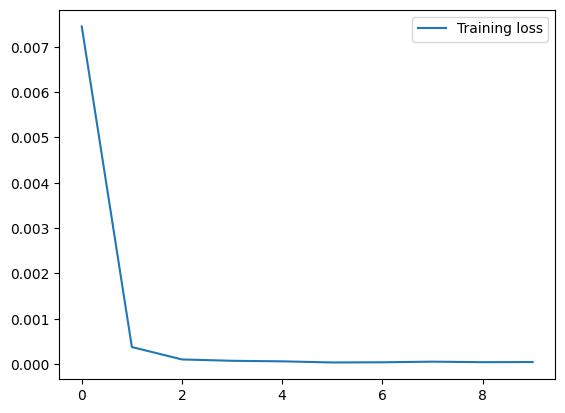

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.004925733897835016


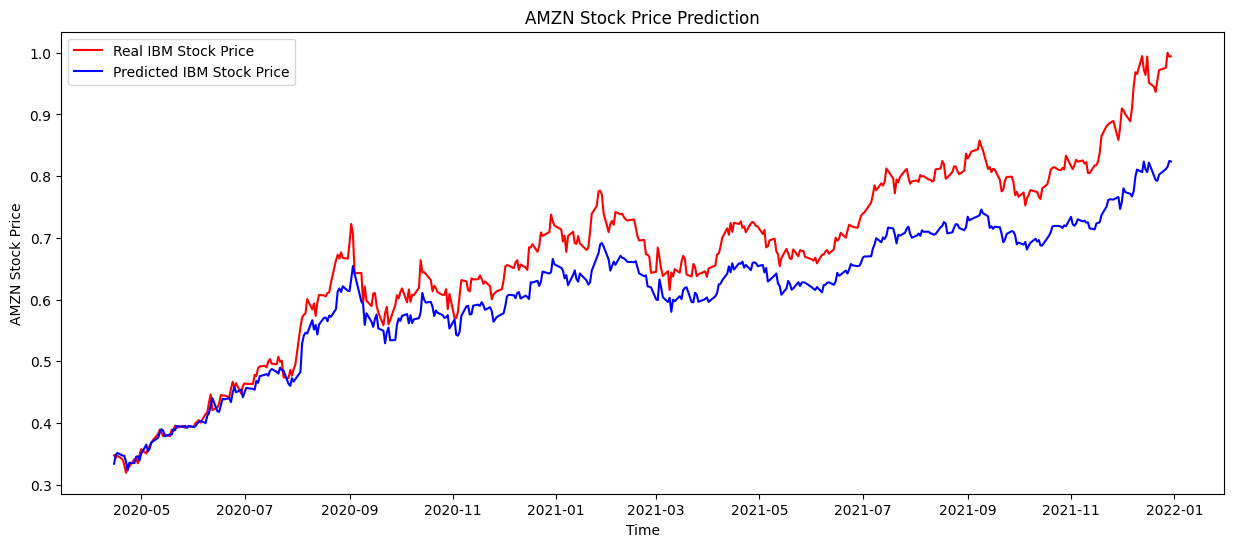

In [129]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = RNN_bi(input_dim = input_dim , hidden_dim = hidden_dim, layer_dim = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

Epoch  0 MSE:  0.0018229593541983463
Epoch  1 MSE:  0.00032359745500175514
Epoch  2 MSE:  0.00010504182127116197
Epoch  3 MSE:  6.327332461645312e-05
Epoch  4 MSE:  4.883268896152651e-05
Epoch  5 MSE:  4.857027738892126e-05
Epoch  6 MSE:  3.9679710550432265e-05
Epoch  7 MSE:  4.950113344259005e-05
Epoch  8 MSE:  3.5492112608016504e-05
Epoch  9 MSE:  4.0787396120658614e-05
Training time: 25.858726978302002


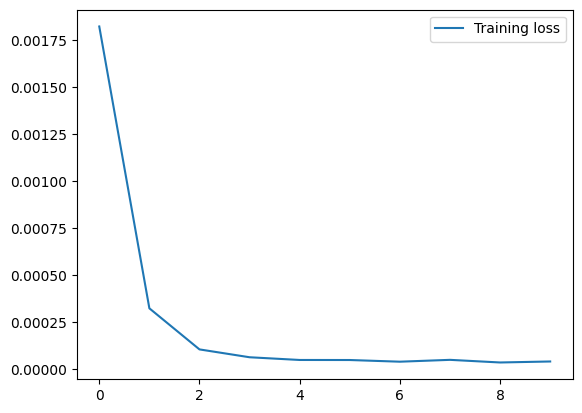

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.00435424130409956


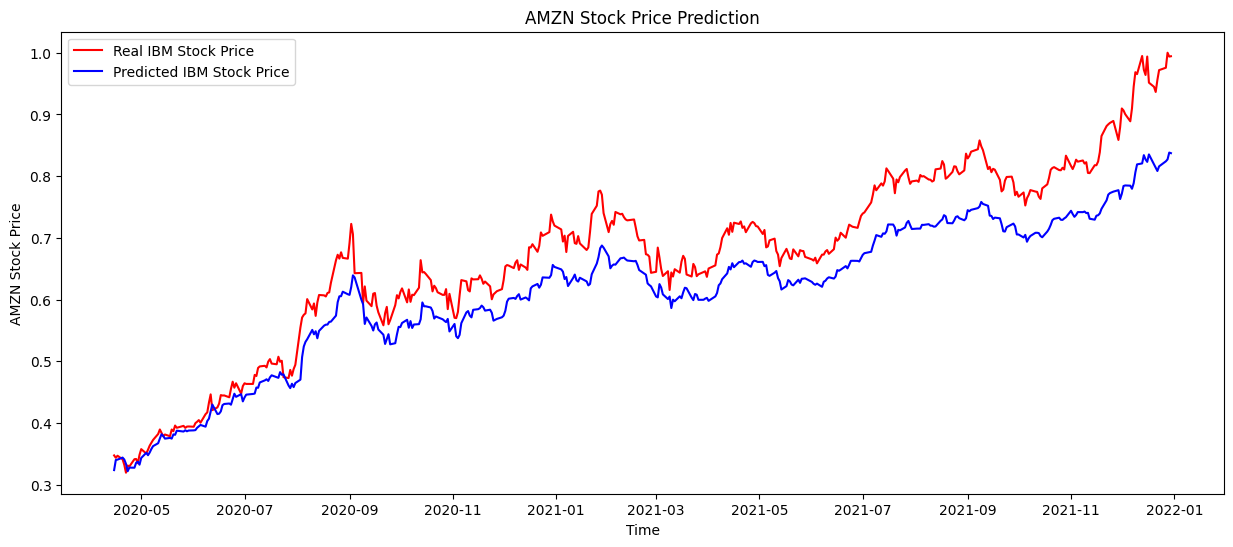

In [130]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = LSTM_v2(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)

Epoch  0 MSE:  0.005145729311713183
Epoch  1 MSE:  0.00030035622111339864
Epoch  2 MSE:  0.00010103530397304583
Epoch  3 MSE:  8.410197047128786e-05
Epoch  4 MSE:  4.408201272644251e-05
Epoch  5 MSE:  3.988834912714282e-05
Epoch  6 MSE:  3.8703804975365565e-05
Epoch  7 MSE:  6.539668962207929e-05
Epoch  8 MSE:  4.874184235146234e-05
Epoch  9 MSE:  3.725017932208162e-05
Training time: 25.830785989761353


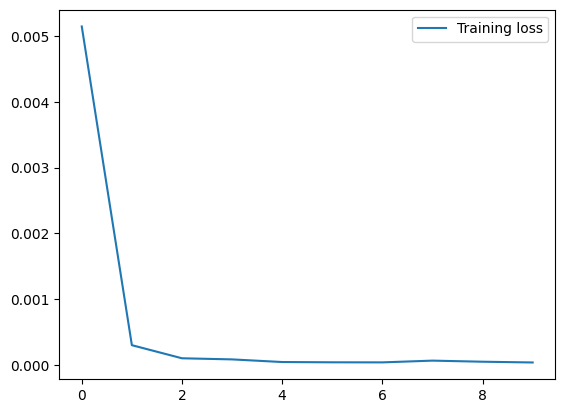

torch.Size([433, 1])
torch.Size([433, 1])
Test loss 0.0046433680690824986


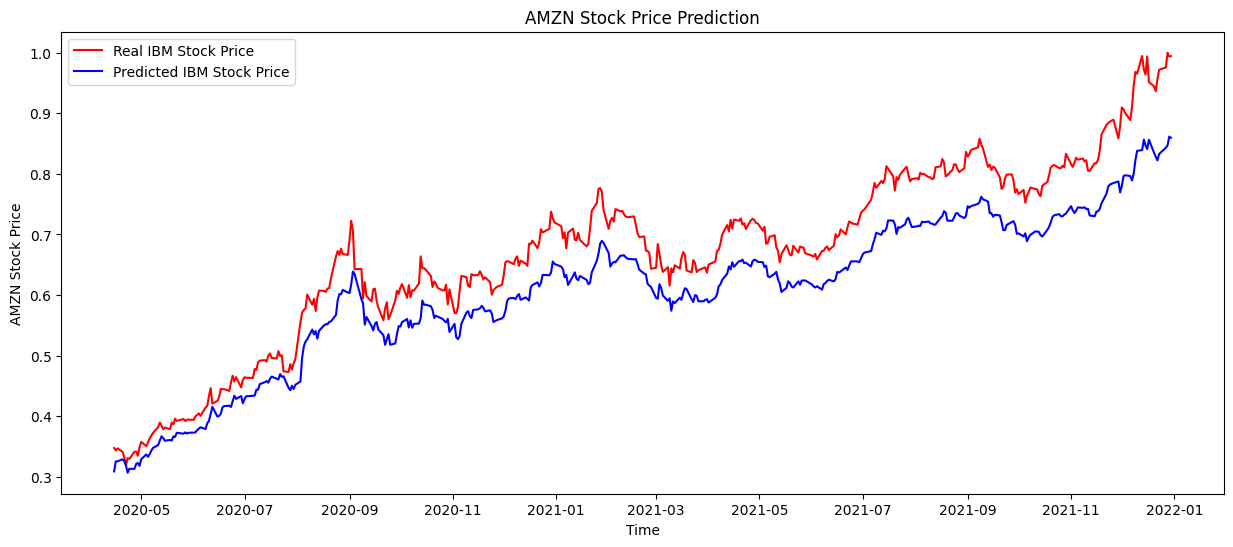

In [131]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

model = GRU_bi(input_dim = input_dim , hidden_dim = hidden_dim, num_layers = num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


hist = fit(num_epochs, train_dl, model, criterion, optimiser)

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


evaluate(model, dataset_multi, X_test, y_test)